## Probabilistic Models

**ResNet18  w/ Dropout 0.5, No Init, with ZeroPadding (complete):**

- Accuracy: 53% (Y1 test), 51% (Y10 test)

- Precision (weighted): 57% (Y1 test), 54% (Y10 test)

- Recall (weighted): 53% (Y1 test), 51% (Y10 test)

- F1 (weighted): 53% (Y1 test), 44% (Y10 test)

## BNN Models

# Load Data and Import Packages

In [2]:
# Import user-defined functions
from ML_training_functions import generate_class_weights, scale_pixels

import os
import datetime
import math
import random
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

# arrays
import numpy as np
np.set_printoptions(edgeitems=25, linewidth=100000)
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10000000
from numpy import arcsinh as arcsinh

# ML
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
# data augmentation
# from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, ReLU
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import (Callback, ModelCheckpoint, EarlyStopping, 
                                        ReduceLROnPlateau, LambdaCallback, LearningRateScheduler)
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, ZeroPadding2D, ReLU,
                                     AveragePooling2D, Add, Conv2D, MaxPool2D, BatchNormalization, 
                                     Input, Flatten, Dense, Dropout)
from tensorflow.keras.initializers import VarianceScaling, RandomUniform, HeNormal

# tensorflow add-ons
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import CyclicalLearningRate, AdamW, ExponentialCyclicalLearningRate

# tensorflow probability
import tensorflow_probability as tfp
tfd = tfp.distributions
# Load the TensorBoard notebook extension
%load_ext tensorboard

import keras_tuner as kt

# sklearn metrics and plotting
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score, 
                             accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, confusion_matrix)

## Plotting
import visualkeras
import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFont
#from tensorflow.keras.utils import plot_model
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

2023-04-14 14:20:41.042664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load year 1 train, test, validation image files (noisy), then create dask array faster compute
X_train_1 = np.load('/deepskieslab/mdunn/images_Y1_train.npy')
X_test_1 = np.load('/deepskieslab/mdunn/images_Y1_test.npy')
X_valid_1 = np.load('/deepskieslab/mdunn/images_Y1_valid.npy')

In [4]:
# Load year 10 train, test, validation image files (pristine) using dask
X_train_10 = np.load('/deepskieslab/mdunn/images_Y10_train.npy')
X_test_10 = np.load('/deepskieslab/mdunn/images_Y10_test.npy')
X_valid_10 = np.load('/deepskieslab/mdunn/images_Y10_valid.npy')

In [5]:
# Load image label files
Y_train = np.load('/deepskieslab/mdunn/labels_train.npy')
Y_test = np.load('/deepskieslab/mdunn/labels_test.npy')
Y_valid = np.load('/deepskieslab/mdunn/labels_valid.npy')

# Pre-process & Verify Data

In [6]:
print( "Data dimensions: ")
# same for years 10 and 1
print("Training Set:", np.shape(X_train_1)) 
print("Test Set:", np.shape(X_test_1))
print("Validation Set:", np.shape(X_valid_1))
print("Training Labels:", np.shape(Y_train))
print("Test Labels:", np.shape(Y_test))
print("Validation Labels:", np.shape(Y_valid))

Data dimensions: 
Training Set: (23487, 3, 100, 100)
Test Set: (6715, 3, 100, 100)
Validation Set: (3355, 3, 100, 100)
Training Labels: (23487, 3)
Test Labels: (6715, 3)
Validation Labels: (3355, 3)


In [8]:
# 3 Classes
class_names = ['Spiral', 'Elliptical', 'Merger']
NUM_CLASSES = len(class_names)

In [9]:
# Dataset is imbalanced, so want to use class weights
class_weights = generate_class_weights(Y_train) # use for training

# See class weights for each set
print('Training class weights:', generate_class_weights(Y_train))
print('Test class weights:', generate_class_weights(Y_test))
print('Validation class weights:', generate_class_weights(Y_valid))

Training class weights: {0: 0.7815713287411401, 1: 1.372304995617879, 2: 1.0082421120412106}
Test class weights: {0: 0.7818139480731168, 1: 1.3723686899652565, 2: 1.0078042923607984}
Validation class weights: {0: 0.7809590316573557, 1: 1.3721881390593047, 2: 1.0093261131167268}


In [10]:
# check data sizes
NUM_TRAIN = 23487
NUM_TEST = 6715
NUM_VALIDATION = 3355
NUM_TOTAL = NUM_TRAIN + NUM_TEST + NUM_VALIDATION
print(NUM_TOTAL)
assert NUM_TOTAL == len(X_train_1) + len(X_test_1) + len(X_valid_1), "total\
training, test, validation samples not equal to total samples - exiting"

33557


In [11]:
def scale_pixels(t):
    #first clip outliers based on global values
    global_min = np.percentile(t, 0.1)
    global_max = np.percentile(t, 99.9)

    for i in range(0, 3):
        #g, r, i
        c = .85/global_max #gets you close to arcsinh(max_x) = 1, arcsinh(min_x) = 0
        t[:,i] = np.clip(t[:,i], global_min, global_max)
        t[:,i] = arcsinh(c*t[:, i])
        t[:,i] = (t[:,i] + 1.0) / 2.0
        
scale_pixels(X_train_1)
scale_pixels(X_test_1)
scale_pixels(X_valid_1)

scale_pixels(X_train_10)
scale_pixels(X_test_10)
scale_pixels(X_valid_10)

# Fully Probabilistic Bayesian Neural Network

In [12]:
# Set seed for reproduclibility
tf.random.set_seed(0)
tf.config.run_functions_eagerly(True)

# Negative log-likelihood loss function
@tf.function
def nll(y_true, y_pred):
  """
  Function should return the negative log-likelihood of each sample
  in y_true given the predicted distribution y_pred.
  """
  return -y_pred.log_prob(y_true)

#### Functions for evaluating, visualizing predictions

In [13]:
# random test predicition examples
examples = [0, 1500, 2500, # spiral galaxies
            3800, 4000, 4200, # galaxy mergers
            5900, 6000, 6200 # elliptical galaxies
           ]

In [11]:
def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    NUM_CLASSES = 3
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num]
    predicted_probabilities = np.empty(shape=(ensemble_size, NUM_CLASSES))
    
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[...][0])
    ax1.axis('off')
    if true_label[0] == 1:
        ax1.set_title('True label: Spiral')
    elif true_label[1] == 1:
        ax1.set_title('True label: Elliptical')
    elif true_label[2] == 1:
        ax1.set_title('True label: Merger')
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(NUM_CLASSES)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(NUM_CLASSES)])     
    bar = ax2.bar(np.arange(NUM_CLASSES), color='red')
    if true_label[0] == 1:
        bar[0].set_color('green')
    elif true_label[1] == 1:
        bar[1].set_color('green')
    elif true_label[2] == 1:
        bar[2].set_color('green')
    ax2.bar(np.arange(NUM_CLASSES), color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(NUM_CLASSES))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Example Model Estimated Probabilities')
    plt.savefig(f'{str(model)}_estimated_probabilities_examples.png')
    plt.show()

## Probabilistic CNN

#### Setup

In [14]:
# Define probabilistic CNN model using ResNet18 architecture
def conv3x3(x, out_planes, stride=1):
    x = ZeroPadding2D(padding=1)(x)
    return Conv2D(filters=out_planes, kernel_size=3, strides=stride)(x)

# Residual block
def basic_block(x, planes, stride=1, downsample=None):
    # Original input
    identity = x

    # First convolutional layer per block
    out = conv3x3(x, planes, stride=stride)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    # Second convolutional layer per block
    out = conv3x3(out, planes)
    out = BatchNormalization()(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = tf.keras.layers.add([identity, out])
    out = Activation('relu')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    # Do downsample if stride not 1
    if stride != 1 or inplanes != planes:
        # Use kernel size 1, stride 2 for convolutional layers in residual blocks 2 and after
        downsample = [
            Conv2D(filters=planes, kernel_size=1, strides=stride),
            BatchNormalization(),
        ]
    # Create residual block; blocks 2 and after will have downsample
    x = basic_block(x, planes, stride, downsample)
    
    # Create 2 residual blocks per module
    for i in range(1, blocks):
        x = basic_block(x, planes)

    return x

def resnet18_prob(x, num_classes=NUM_CLASSES):
    # First convolutional layer is 7x7 with 64 output channels and stride 2, then Max-pooling layer with stride 2
    x = ZeroPadding2D(padding=3)(x)
    x = Conv2D(filters=64, kernel_size=7, strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=1)(x)
    x = MaxPool2D(pool_size=3, strides=2)(x)

    # ResNet18 uses two residual blocks for each module (filter size) here, 4 convolutional layers per module
    # First 2 blocks use stride 1
    x = make_layer(x, 64, 2)
    # All layers after this use stride 2
    x = make_layer(x, 128, 2, stride=2)
    x = make_layer(x, 256, 2, stride=2)
    x = make_layer(x, 512, 2, stride=2)

    # Final layers
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)
    distribution_params = Dense(tfp.layers.OneHotCategorical.params_size(num_classes), activation='relu')(x)
    outputs = tfp.layers.OneHotCategorical(num_classes, 
                                           convert_to_tensor_fn=tfp.distributions.Distribution.mode)(distribution_params)

    return outputs

In [30]:
def model_builder(hp):
    # Initialize probabilistic model
    inputs = Input(shape = (3, 100, 100))
    outputs = resnet18_prob(inputs)
    model = Model(inputs, outputs)

    ## Compile Model
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[1e-2, 1e-3, 1e-4, 
                                         1e-5, 1e-6, 1e-7])
    optimizer = Adam(lr=hp_learning_rate)
    model.compile(optimizer=optimizer, loss=nll, metrics=['accuracy'])
    model.summary()
    return model

# instantiate the Hyperband tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     seed=0,
                     max_epochs=100)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


#### Train

In [31]:
## Define Callback Functions
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "Prob ResNet18"

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10), 
      ModelCheckpoint(filepath='prob_resnet18_best_weights', 
                      monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tf.keras.callbacks.TensorBoard(log_dir=log_dir)
      #ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=5, factor=0.1)
      ]

In [32]:
# Set seed for reproduclibility
tf.random.set_seed(0)
batch_size = 16

# Run the hyperparameter search
tuner.search(X_train_1, Y_train, 
             batch_size = batch_size,
             epochs = 100,              
             validation_data = (X_valid_1, Y_valid),
             shuffle = True,
             class_weight = class_weights,
             verbose = 1,
             callbacks = es
            )

Trial 6 Complete [00h 04m 46s]
val_accuracy: 0.4414306879043579

Best val_accuracy So Far: 0.4414306879043579
Total elapsed time: 00h 19m 02s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [36]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]

print(f"""
The hyperparameter search is complete. The optimal 
learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

The hyperparameter search is complete. The optimal 
         learning rate for the optimizer is 1e-06.
         


In [ ]:
# Build the model with the optimal hyperparameters, train probabilistic CNN on the data  
resnet18_prob_model = tuner.hypermodel.build(best_hps)

batch_size = 16
NUM_EPOCH = 250
history_prob = resnet18_prob_model.fit(X_train_1, Y_train,
                                        batch_size = batch_size,
                                        epochs = NUM_EPOCH,              
                                        validation_data = (X_valid_1, Y_valid),
                                        shuffle = True,
                                        class_weight = class_weights,
                                        verbose = 1,
                                        callbacks = es
                                        )

# Save Probabilistic model data
resnet18_prob_model.save(filepath = f'Y1_ResNet18_Dropout_Probabilistic', 
                         include_optimizer = True, overwrite = True)

# Saving history as .npy file for future use
np.save(f'Y1_ResNet18_Dropout_Probabilistic_history.npy', history_prob.history)

Epoch 1/250
1468/1468 [==============================] - ETA: 0s - loss: 1.2148 - accuracy: 0.3810
Epoch 1: val_accuracy did not improve from 0.59583
1468/1468 [==============================] - 138s 94ms/step - loss: 1.2148 - accuracy: 0.3810 - val_loss: 1.0842 - val_accuracy: 0.4629
Epoch 2/250
1468/1468 [==============================] - ETA: 0s - loss: 1.1342 - accuracy: 0.4194
Epoch 2: val_accuracy did not improve from 0.59583
1468/1468 [==============================] - 138s 94ms/step - loss: 1.1342 - accuracy: 0.4194 - val_loss: 1.0613 - val_accuracy: 0.4802
Epoch 3/250
1468/1468 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.4201
Epoch 3: val_accuracy did not improve from 0.59583
1468/1468 [==============================] - 140s 96ms/step - loss: 1.1110 - accuracy: 0.4201 - val_loss: 1.0754 - val_accuracy: 0.4516
Epoch 4/250
1468/1468 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.4299
Epoch 4: val_accuracy did not improve from 

In [ ]:
%tensorboard --logdir logs/fit

In [38]:
# Plot Probabilistic model training history
acc = history_prob.history['accuracy']
val_acc = history_prob.history['val_accuracy']

loss = history_prob.history['loss']
val_loss = history_prob.history['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Y1 ResNet18 with Dropout Probabilistic Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 with Dropout Probabilistic Accuracy Training History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Y1 ResNet18 with Dropout Probabilistic Loss Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 with Dropout Probabilistic Loss Training History")
plt.show()

NameError: name 'history_prob' is not defined

#### Evaluate Probabilistic Model on Y1 and Y10 test data

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_prob_model.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(resnet18_prob_model.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y1 ResNet18 with Dropout Probabilistic Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_Dropout_Probabilistic_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 with Dropout Probabilistic Test ROC Curves')
plt.savefig('Y1_ResNet18_Dropout_Probabilistic_test_ROC')
plt.show()

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_prob_model.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(resnet18_prob_model.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y1 ResNet18 with Dropout Probabilistic Y10 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_Dropout_Probabilistic_Y10_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 with Dropout Probabilistic Y10 Test ROC Curves')
plt.savefig('Y1_ResNet18_Dropout_Probabilistic_Y10_test_ROC')
plt.show()

#### Analyze and visualize predictions

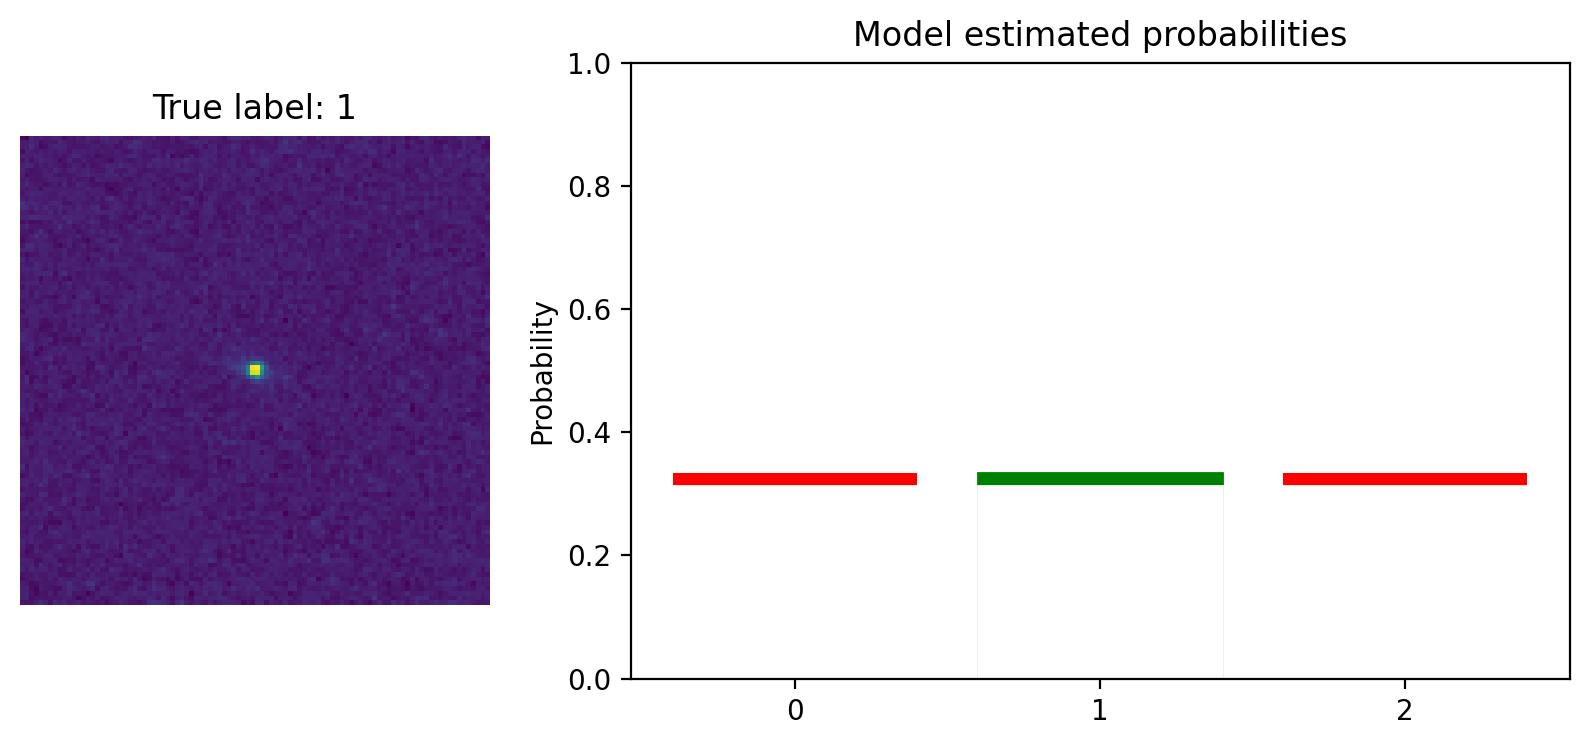

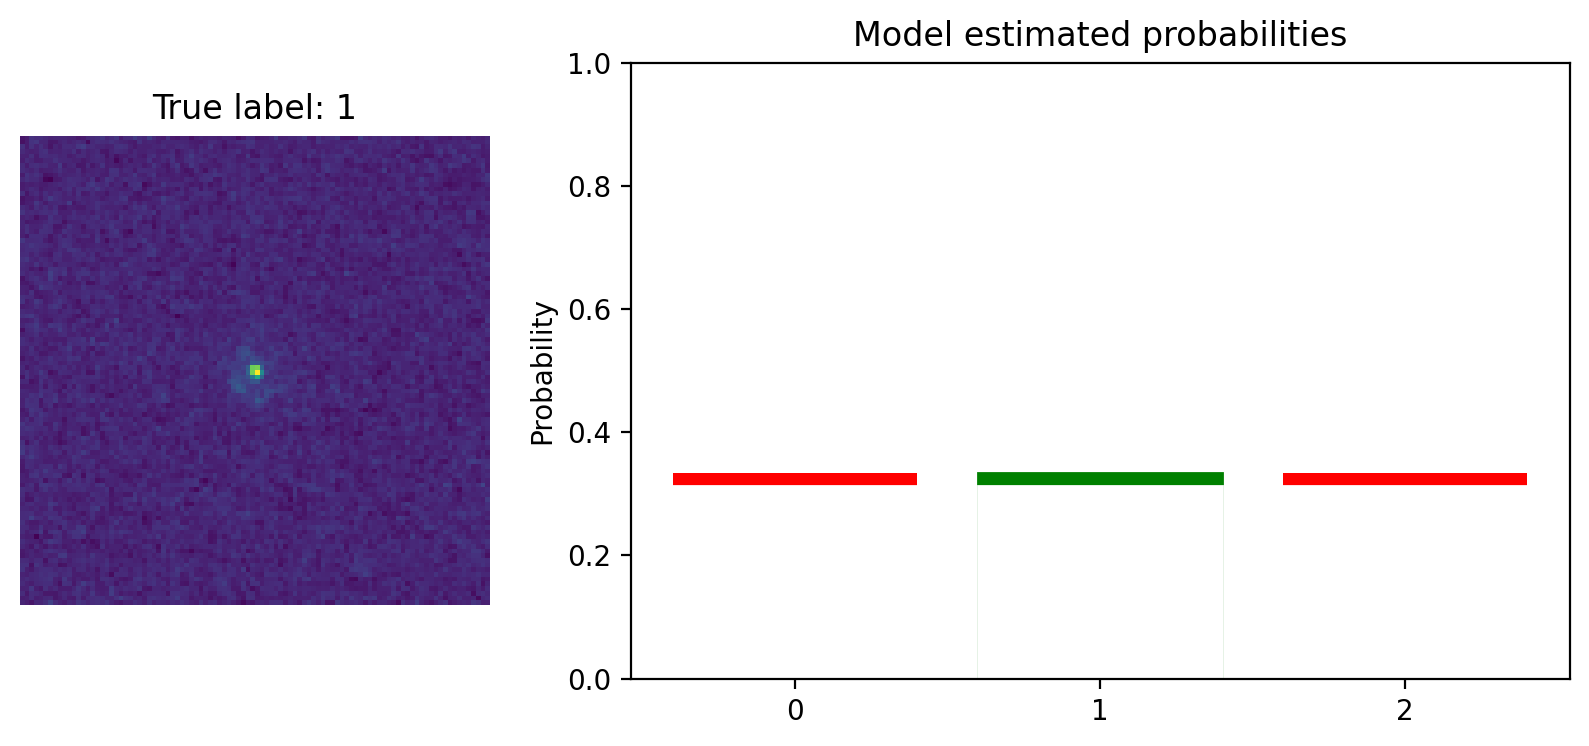

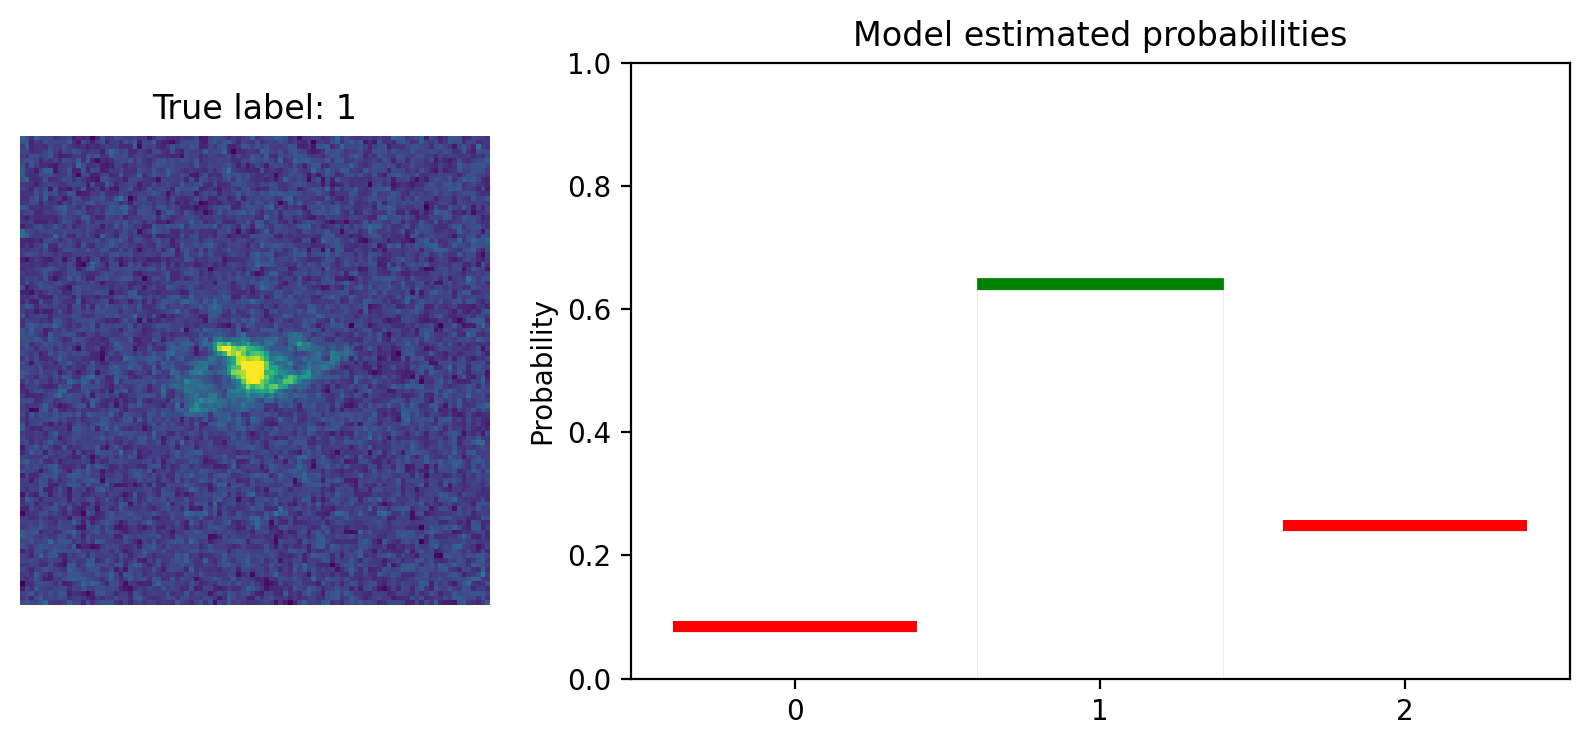

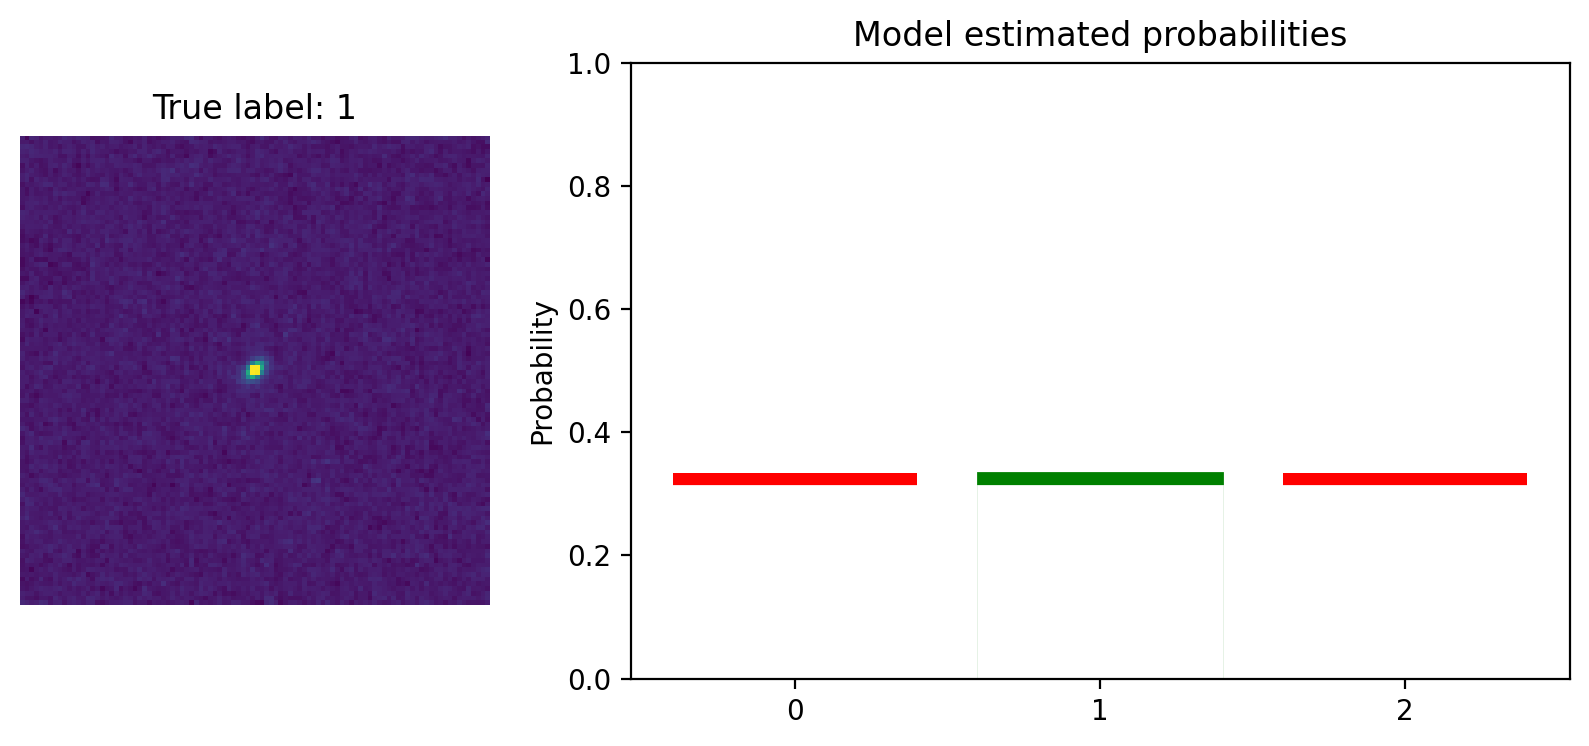

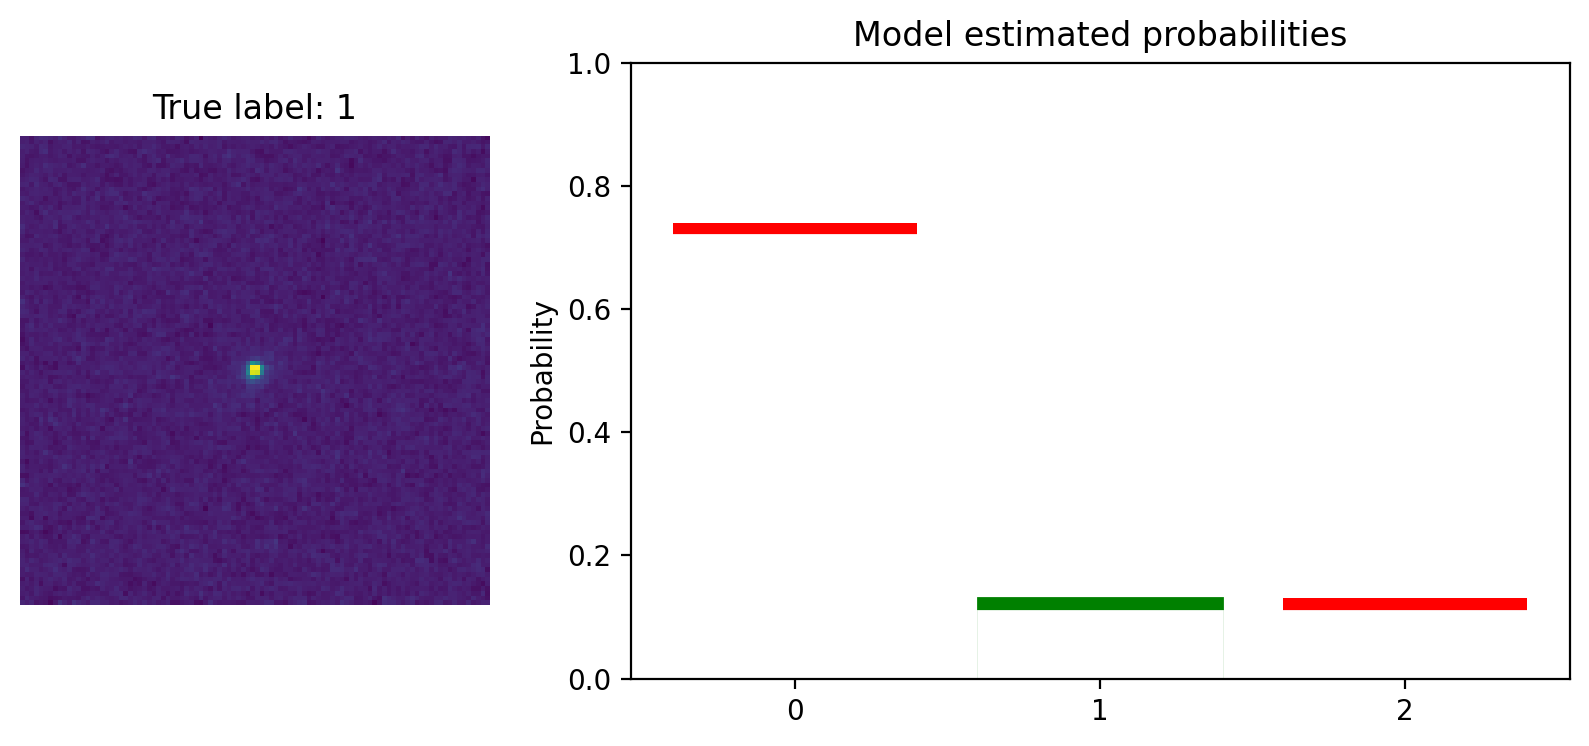

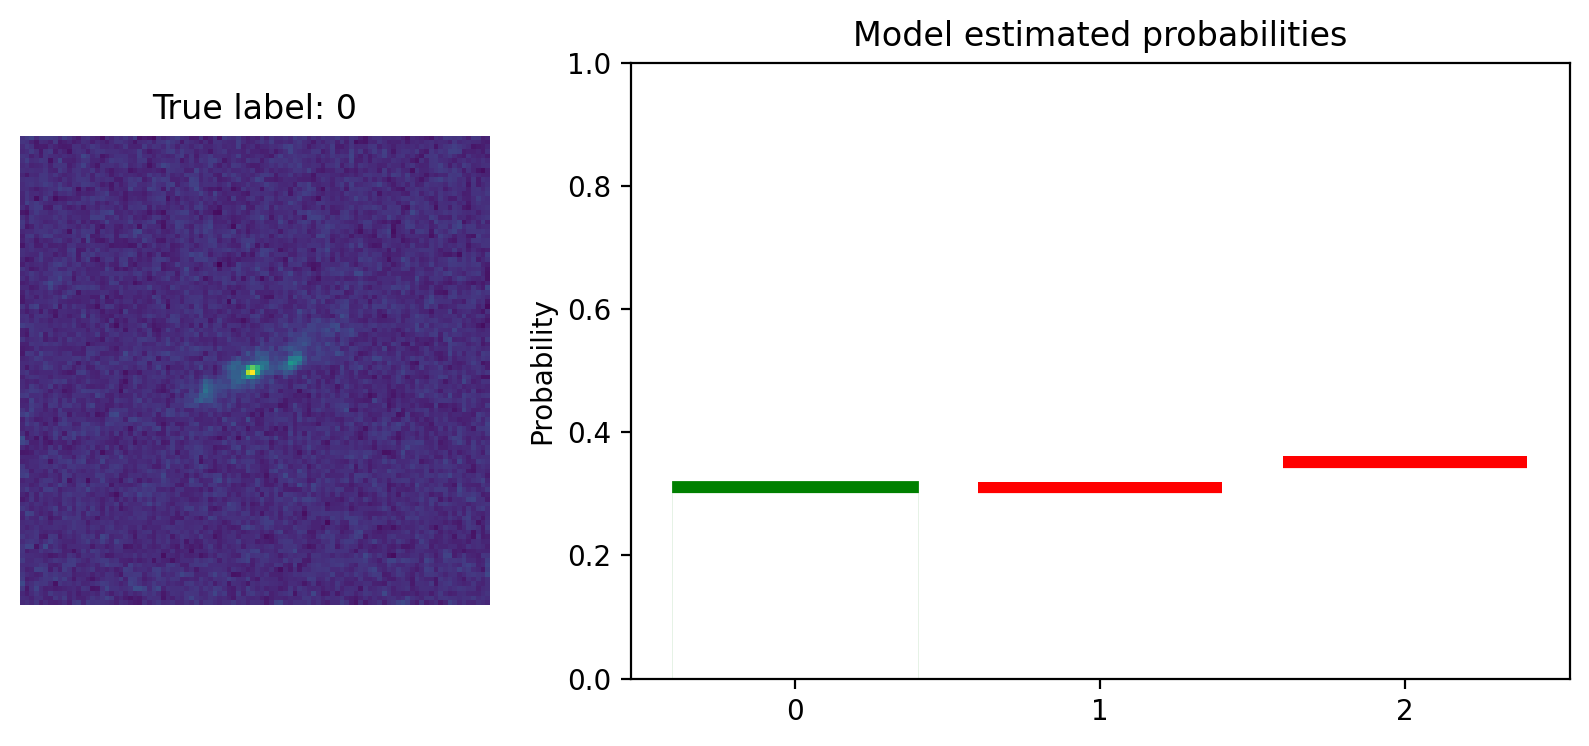

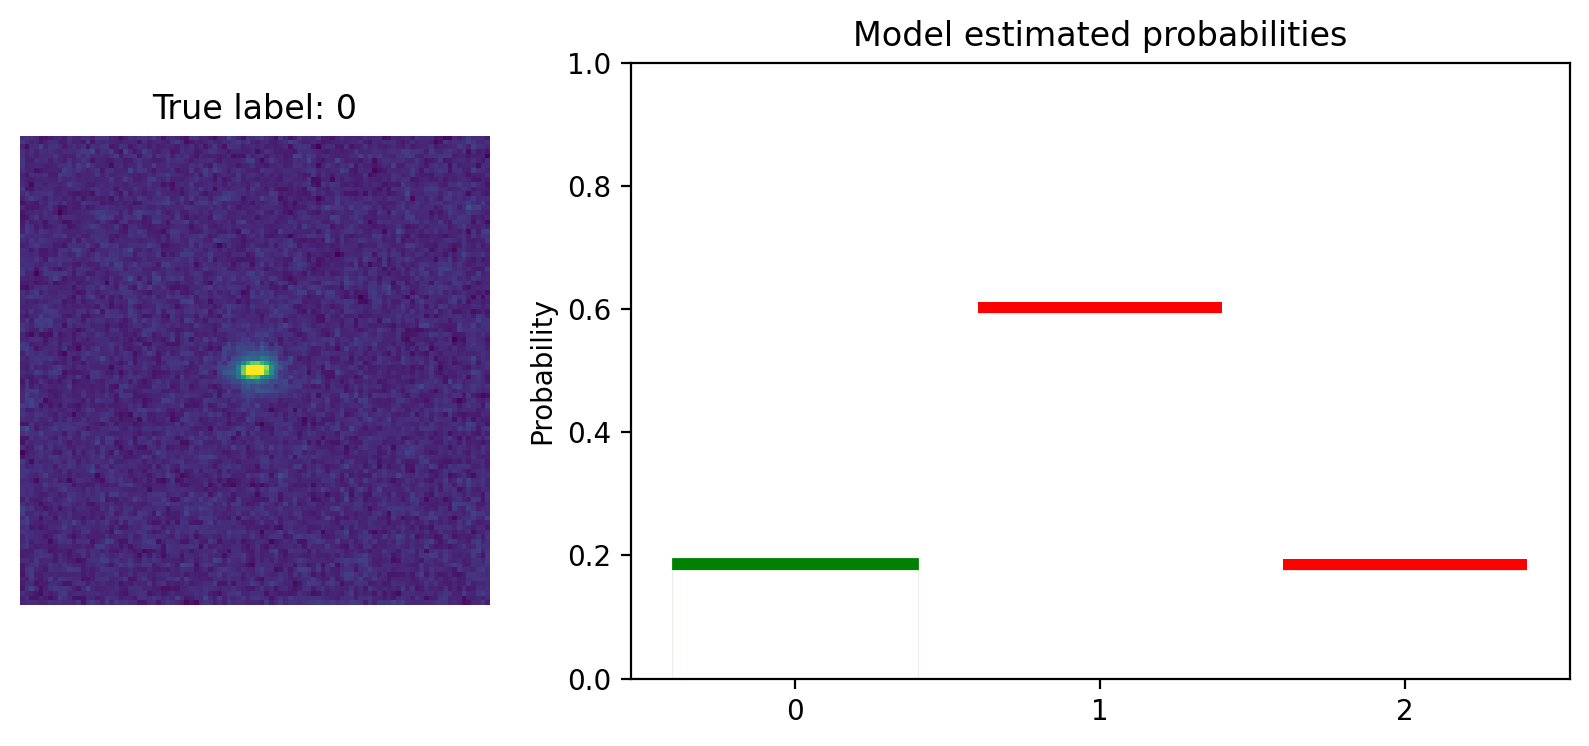

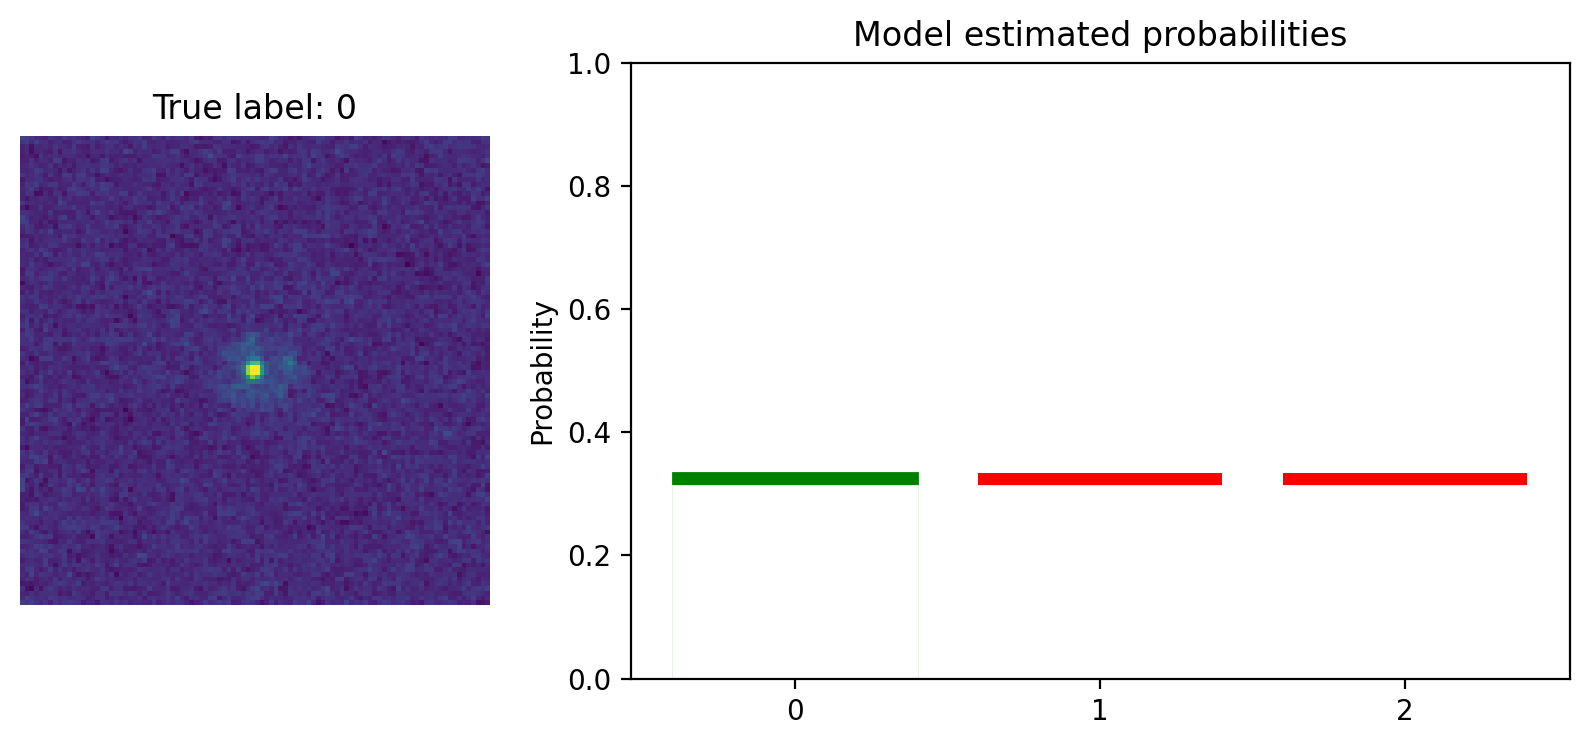

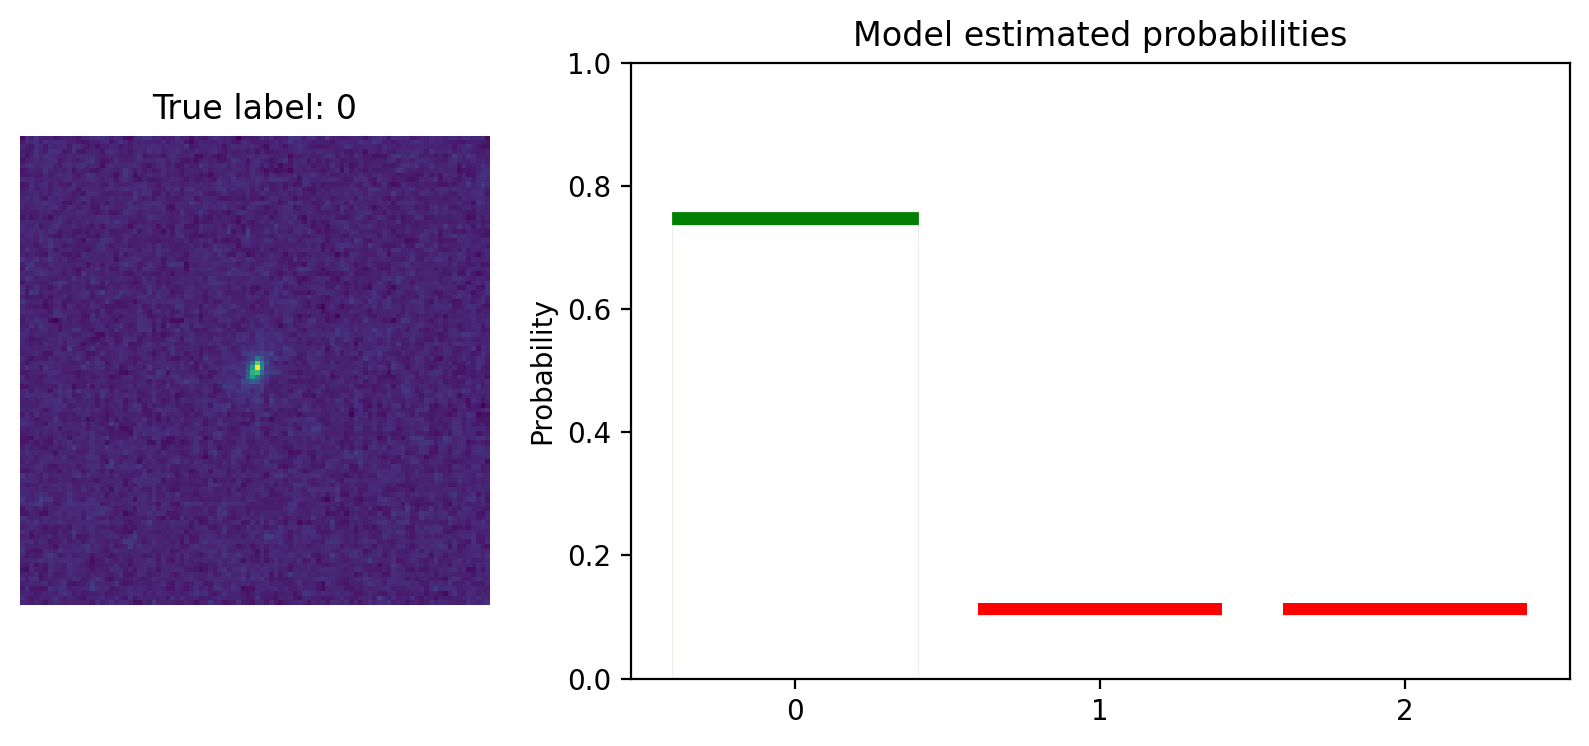

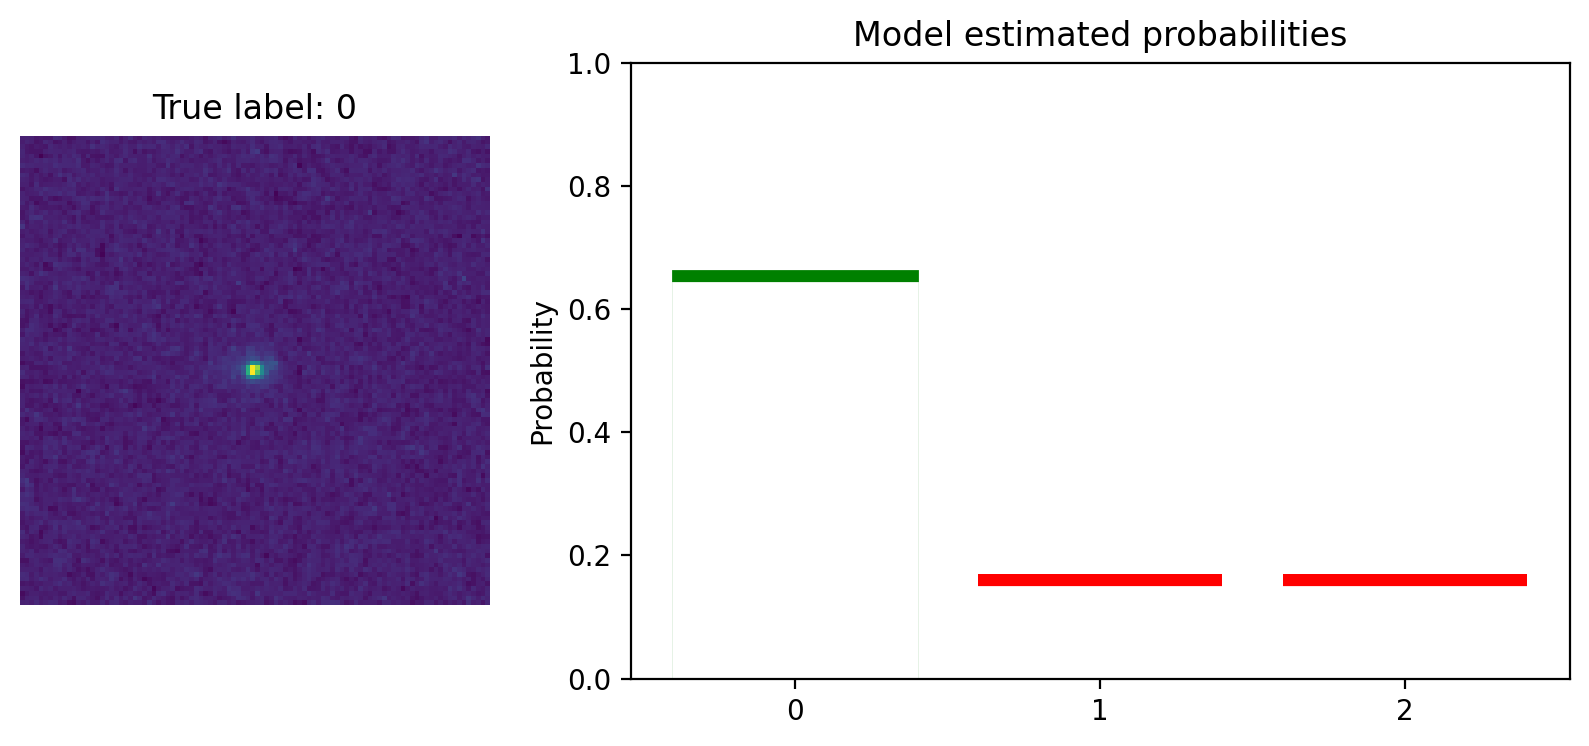

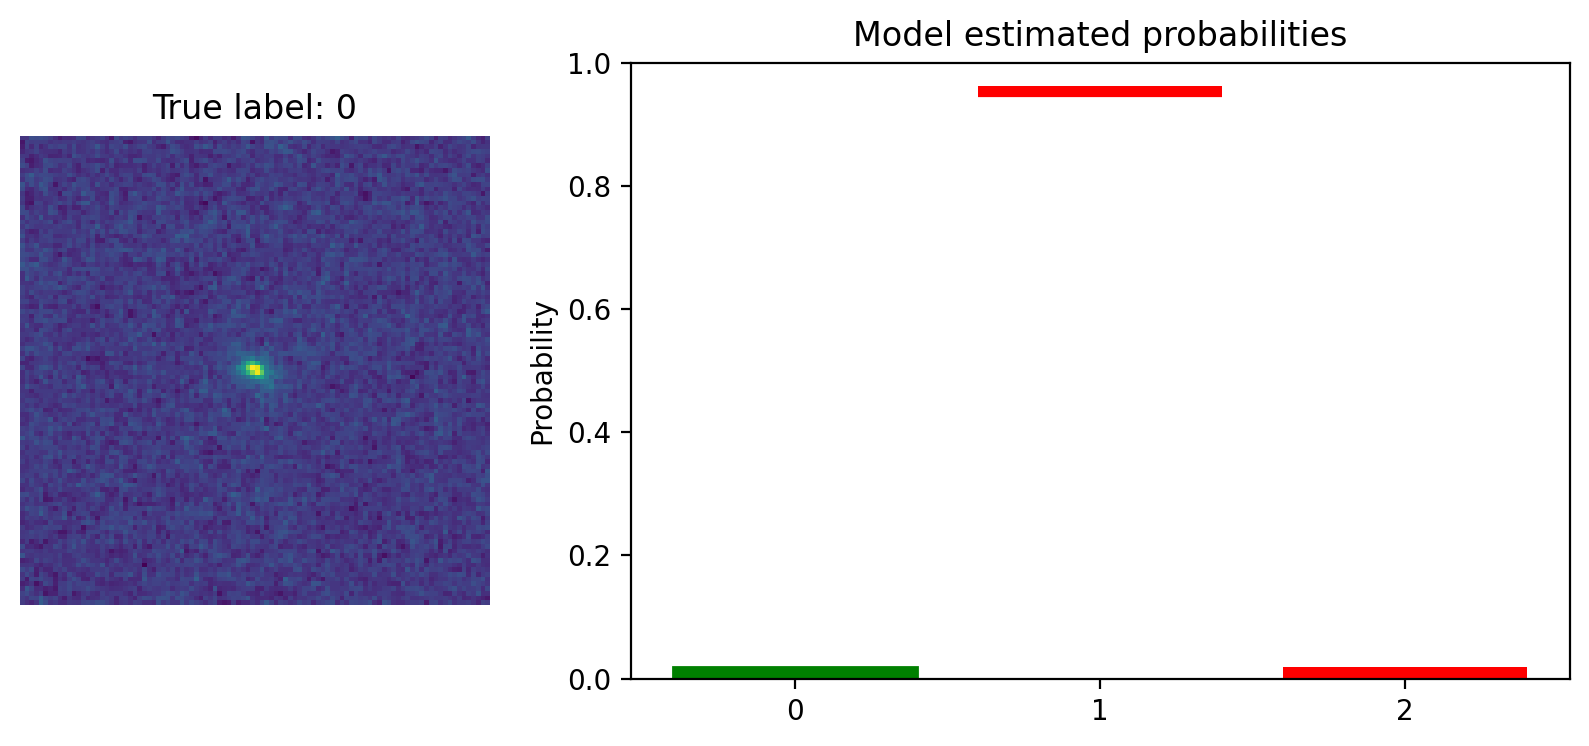

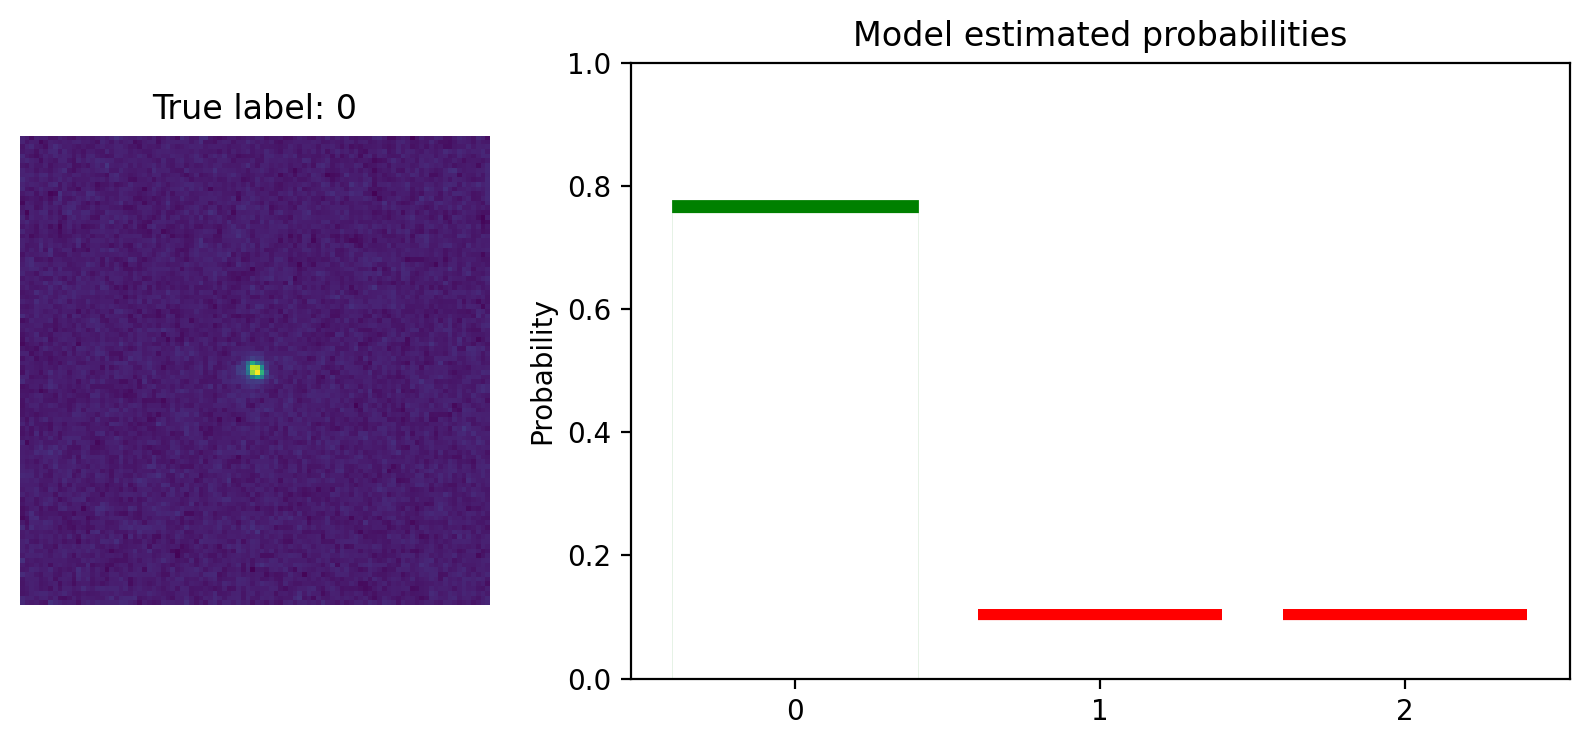

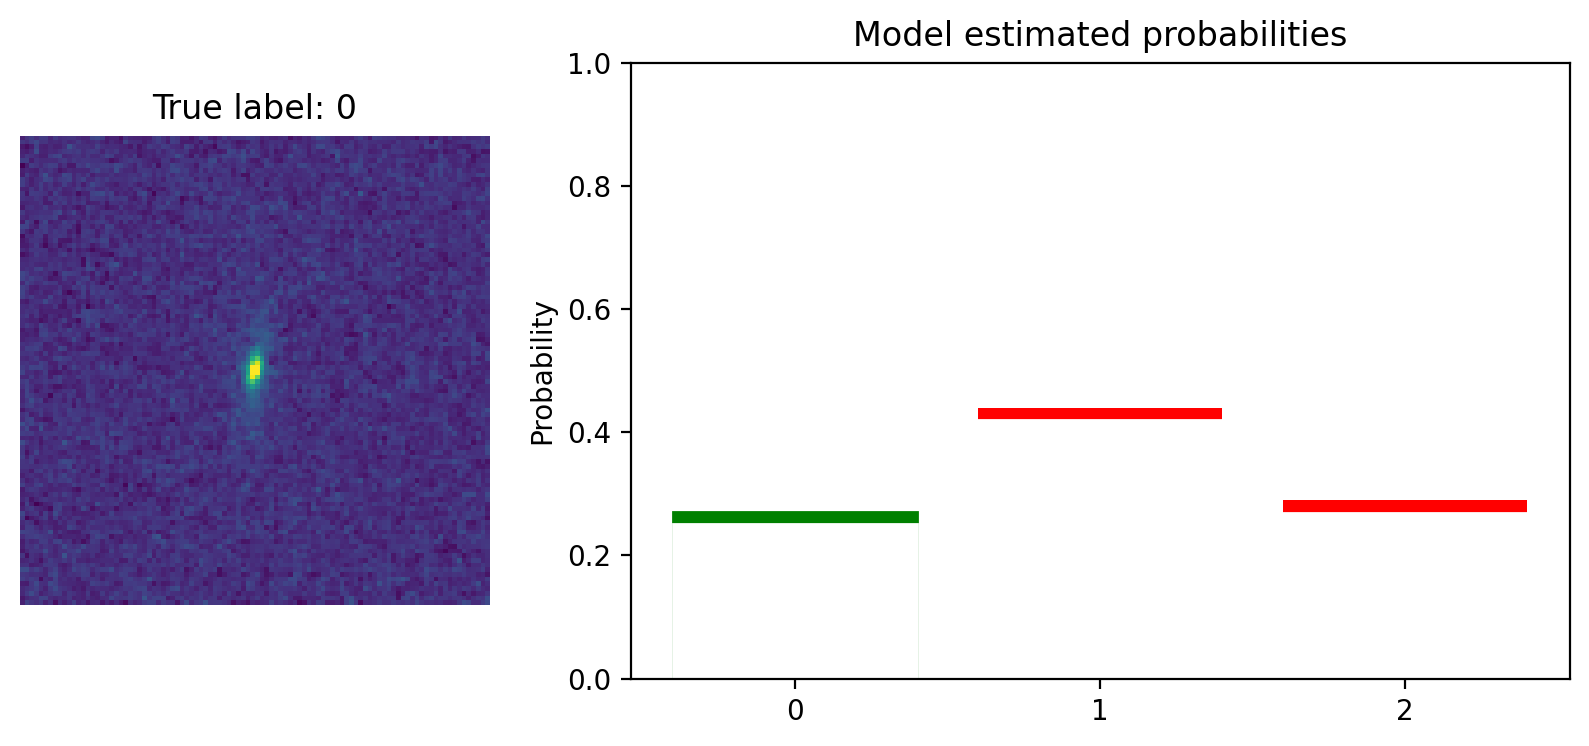

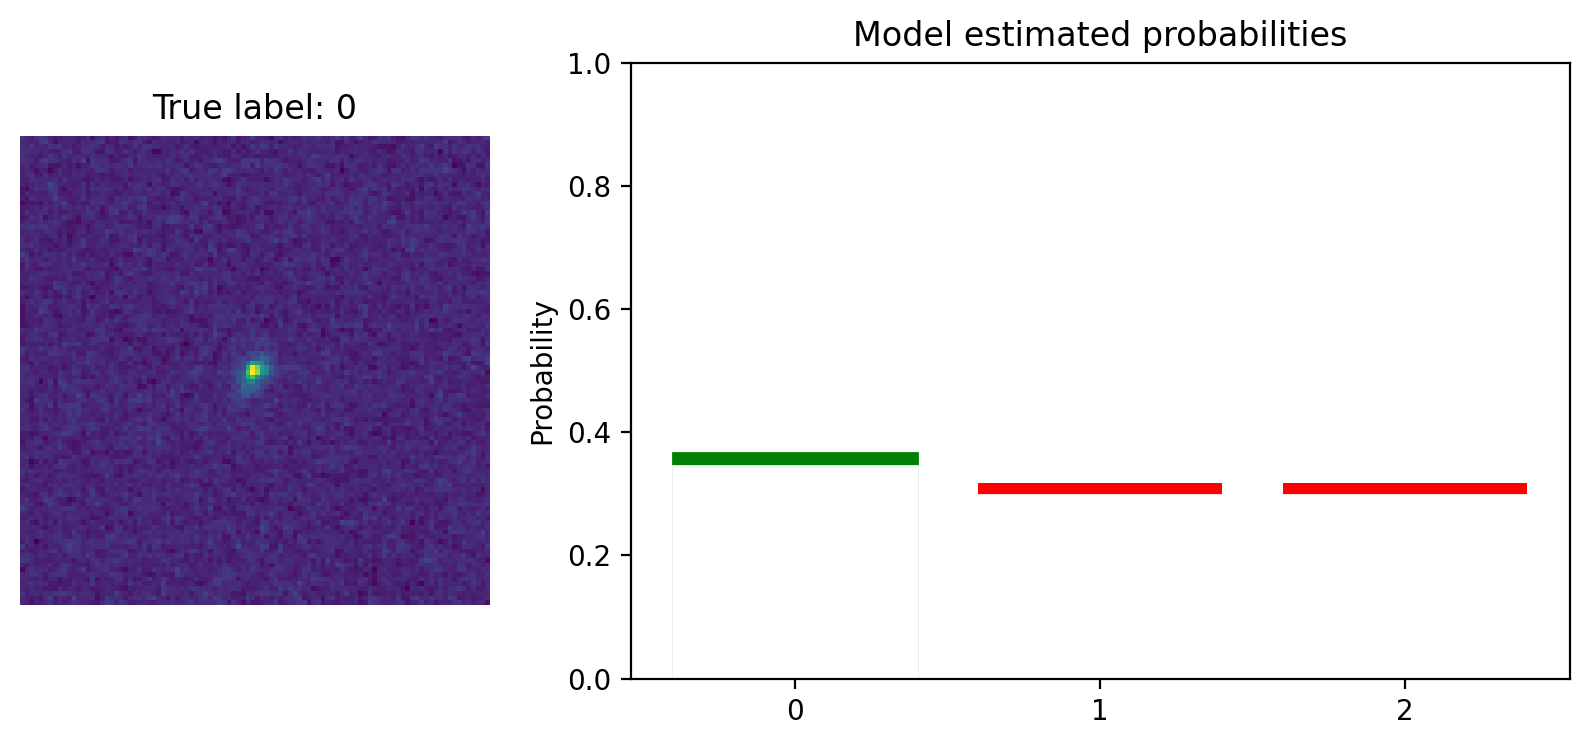

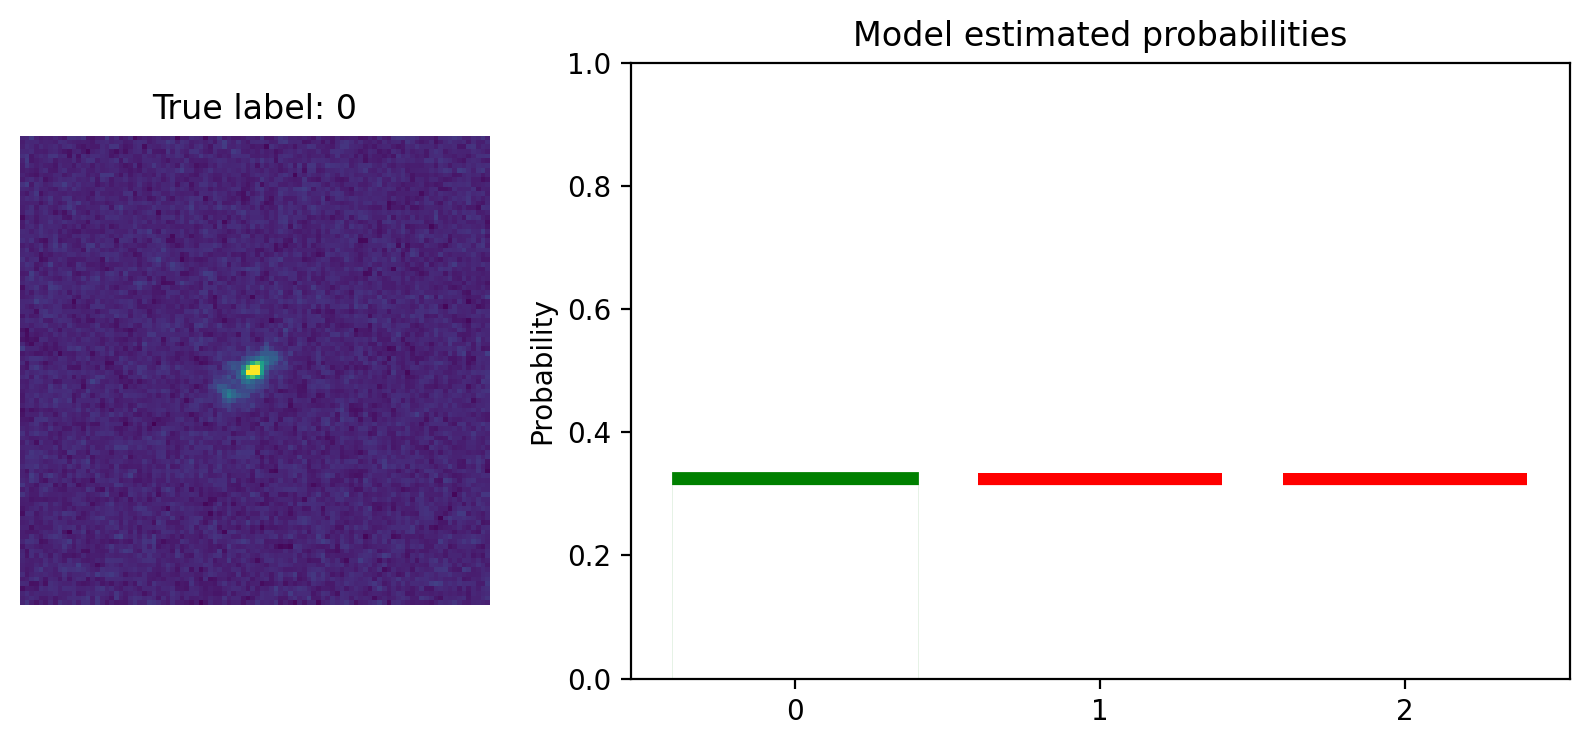

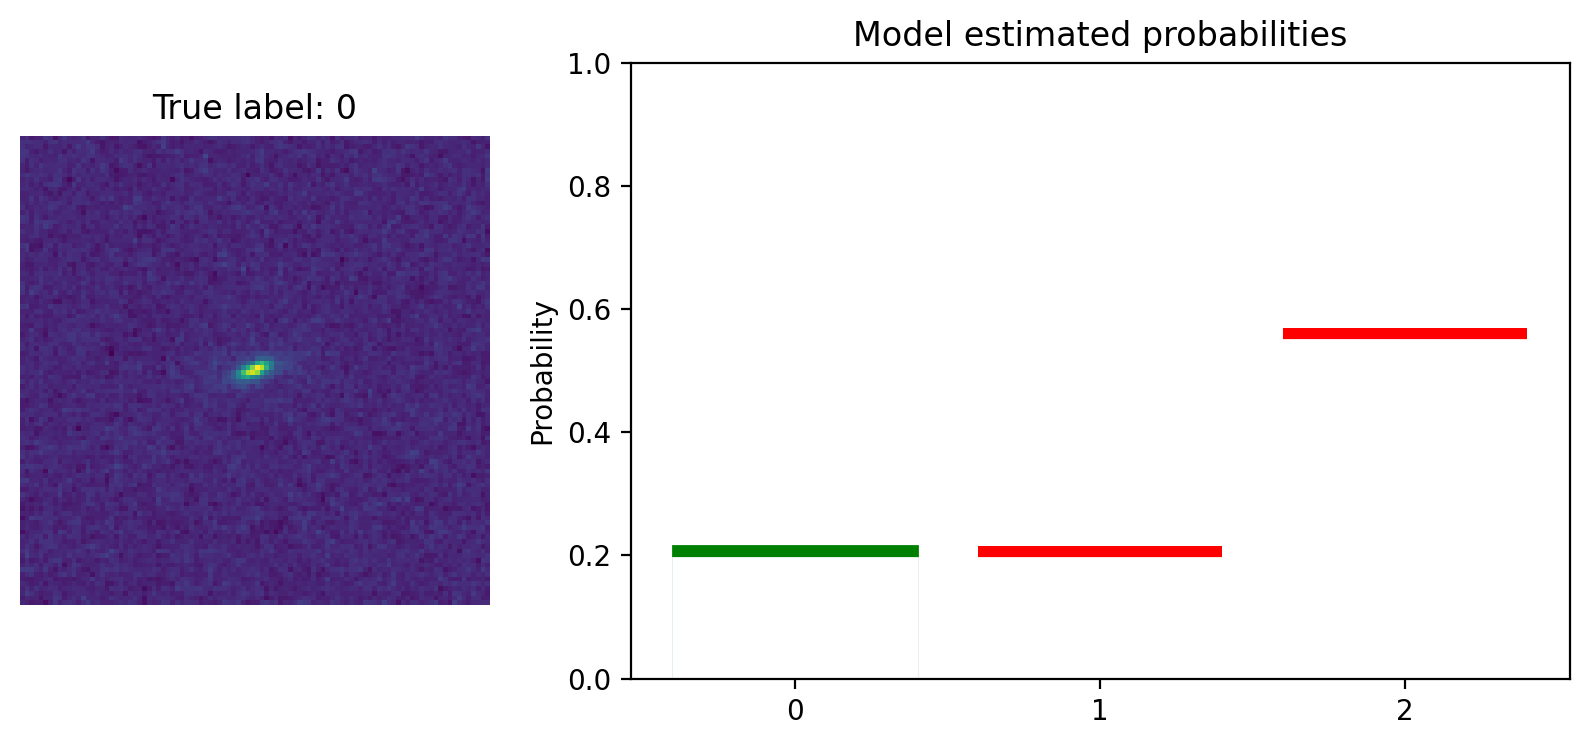

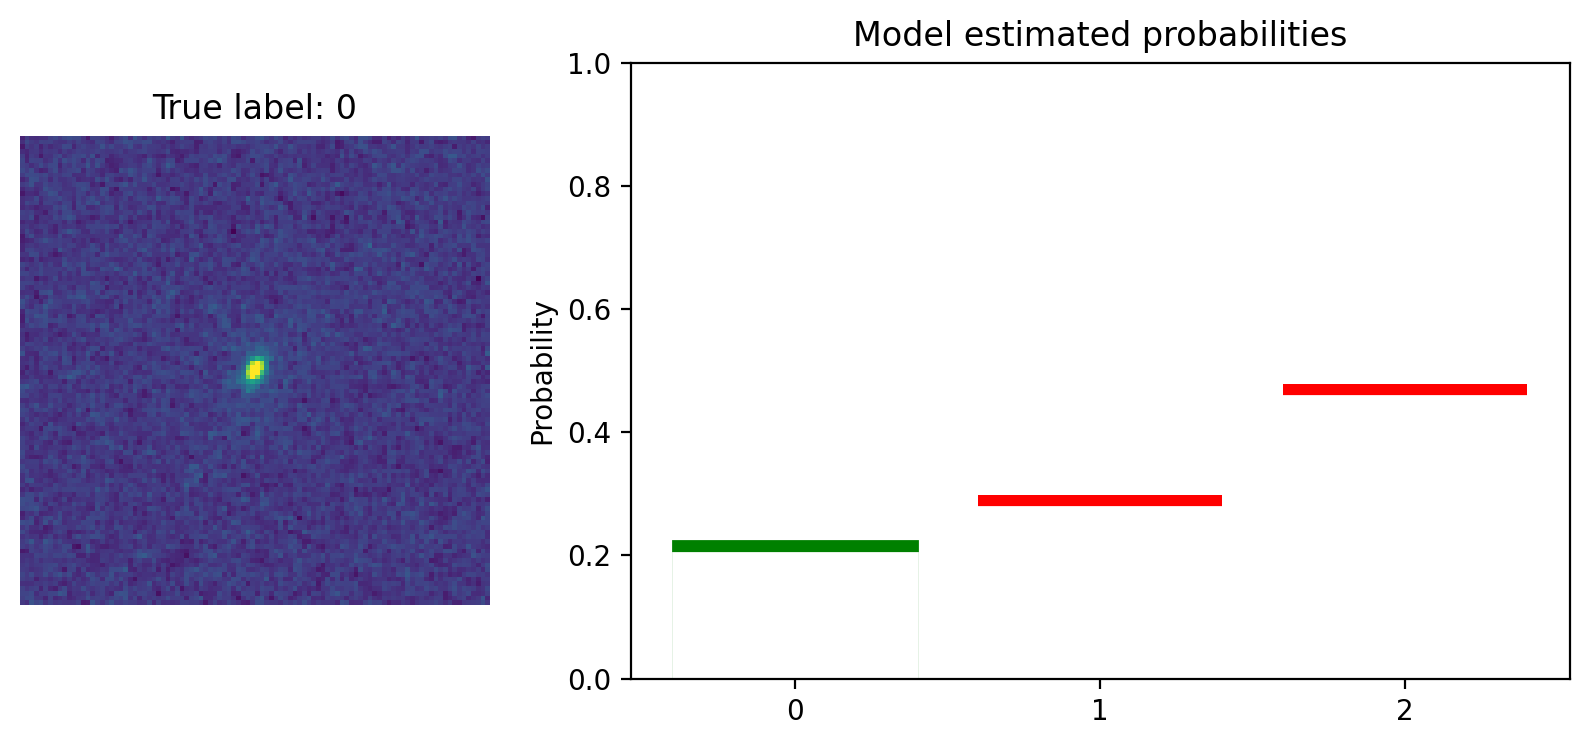

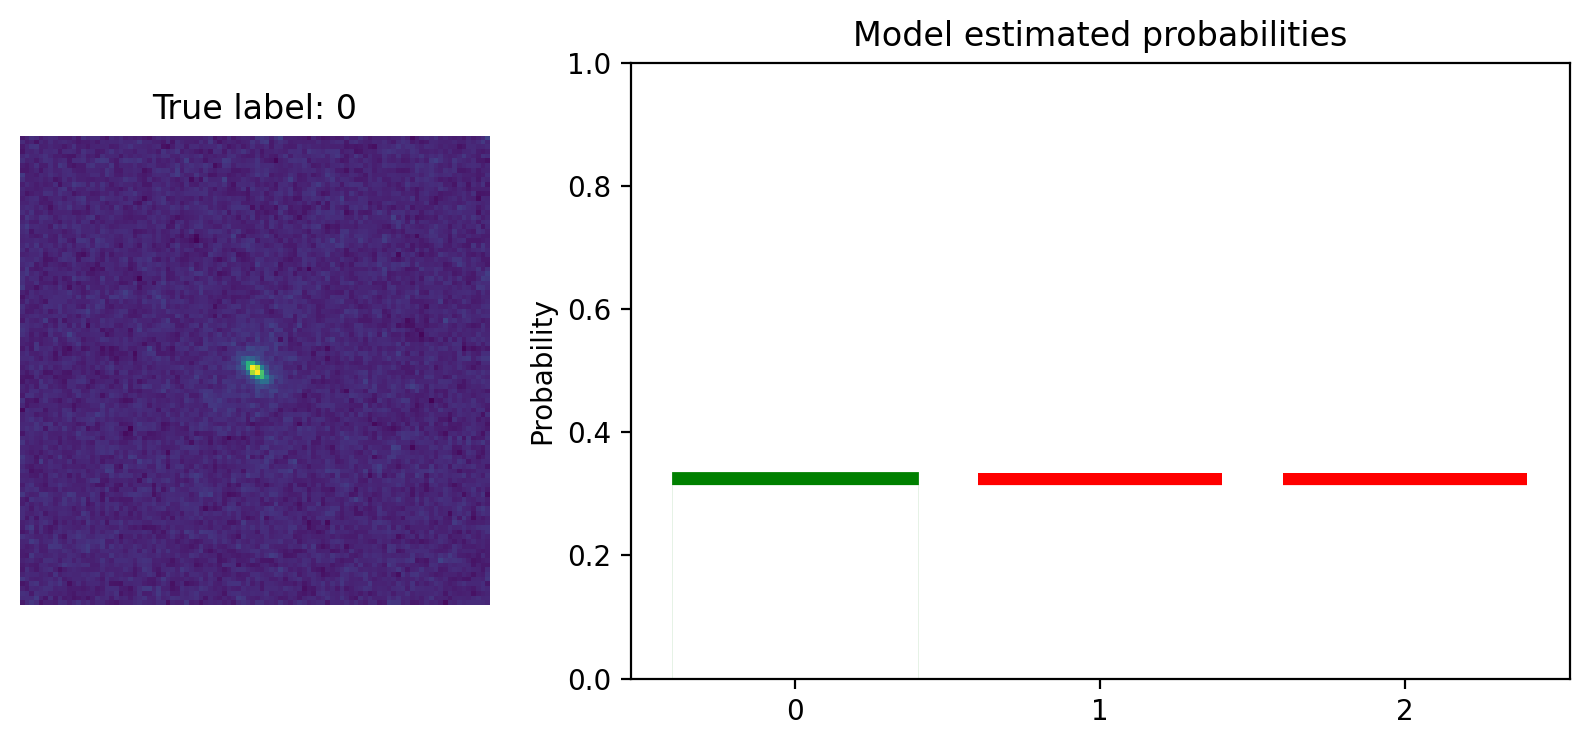

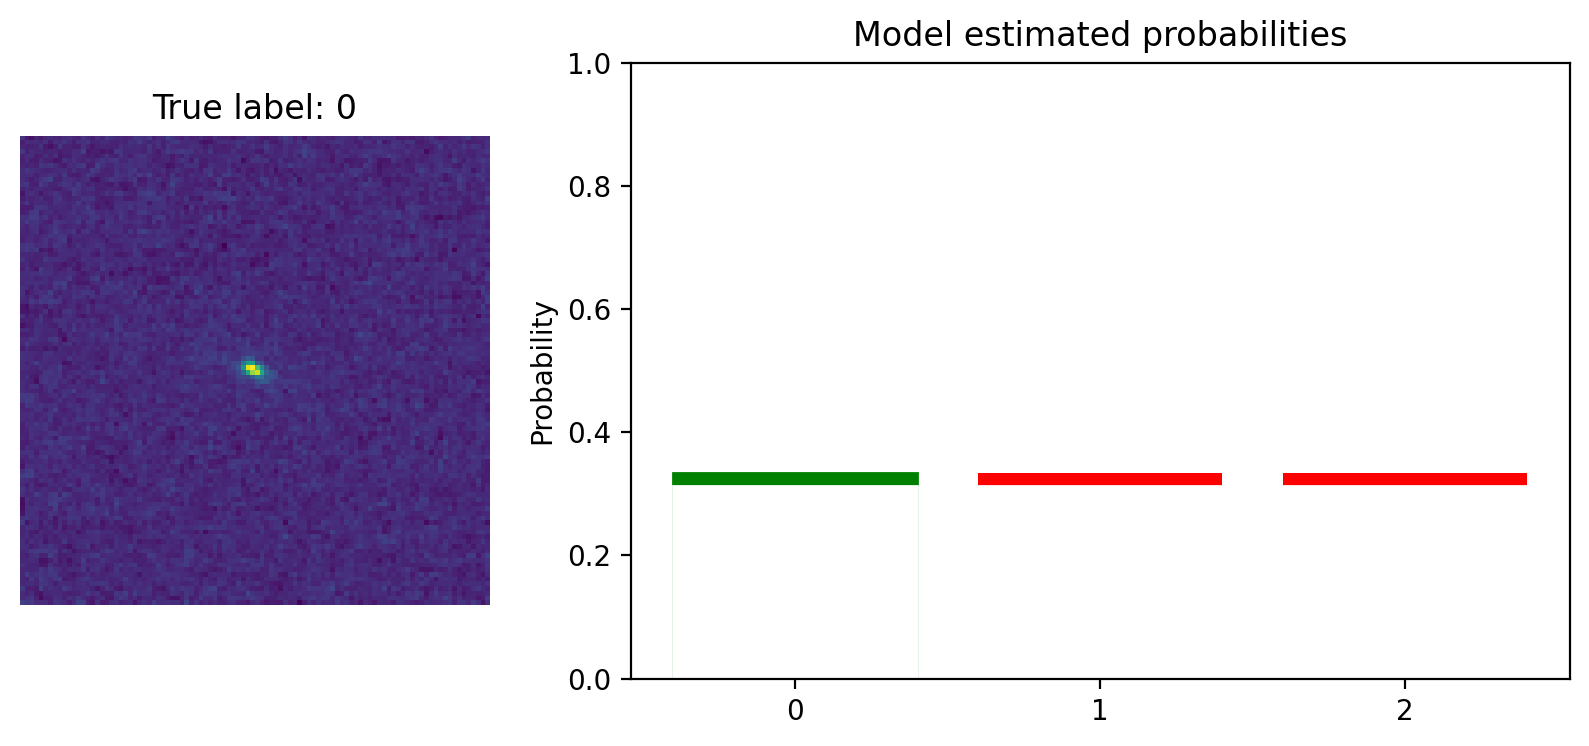

In [60]:
# Evaluate and visualize for Y1 test data
for i in examples:
    image = X_test_1[i]
    true_label = Y_test[i, 0]
    predicted_probabilities = np.empty(shape=(1, 3))
    
    for i in range(1):
        predicted_probabilities[i] = resnet18_prob_model(image[np.newaxis, :]).mean().numpy()[0]
        
    model_prediction = resnet18_prob_model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[...][0])
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    # make plots of probabilities that the model estimates
    pct_5 = np.array([np.percentile(predicted_probabilities[:, i], 0.5) for i in range(3)])
    pct_95 = np.array([np.percentile(predicted_probabilities[:, i], 95.) for i in range(3)])    
    bar = ax2.bar(np.arange(3), pct_95, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(3), pct_5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(3))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model Estimated Probabilities')
    plt.show()

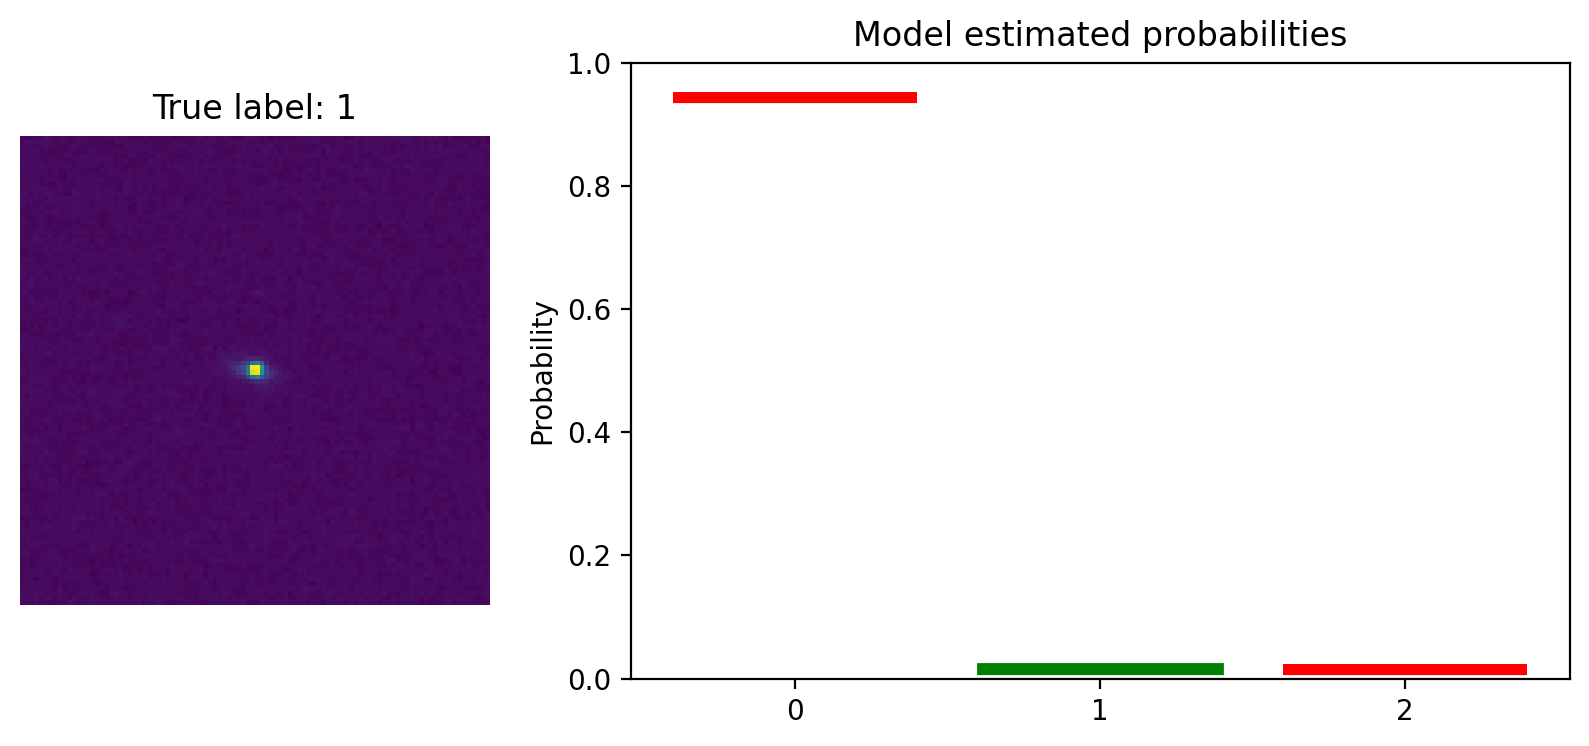

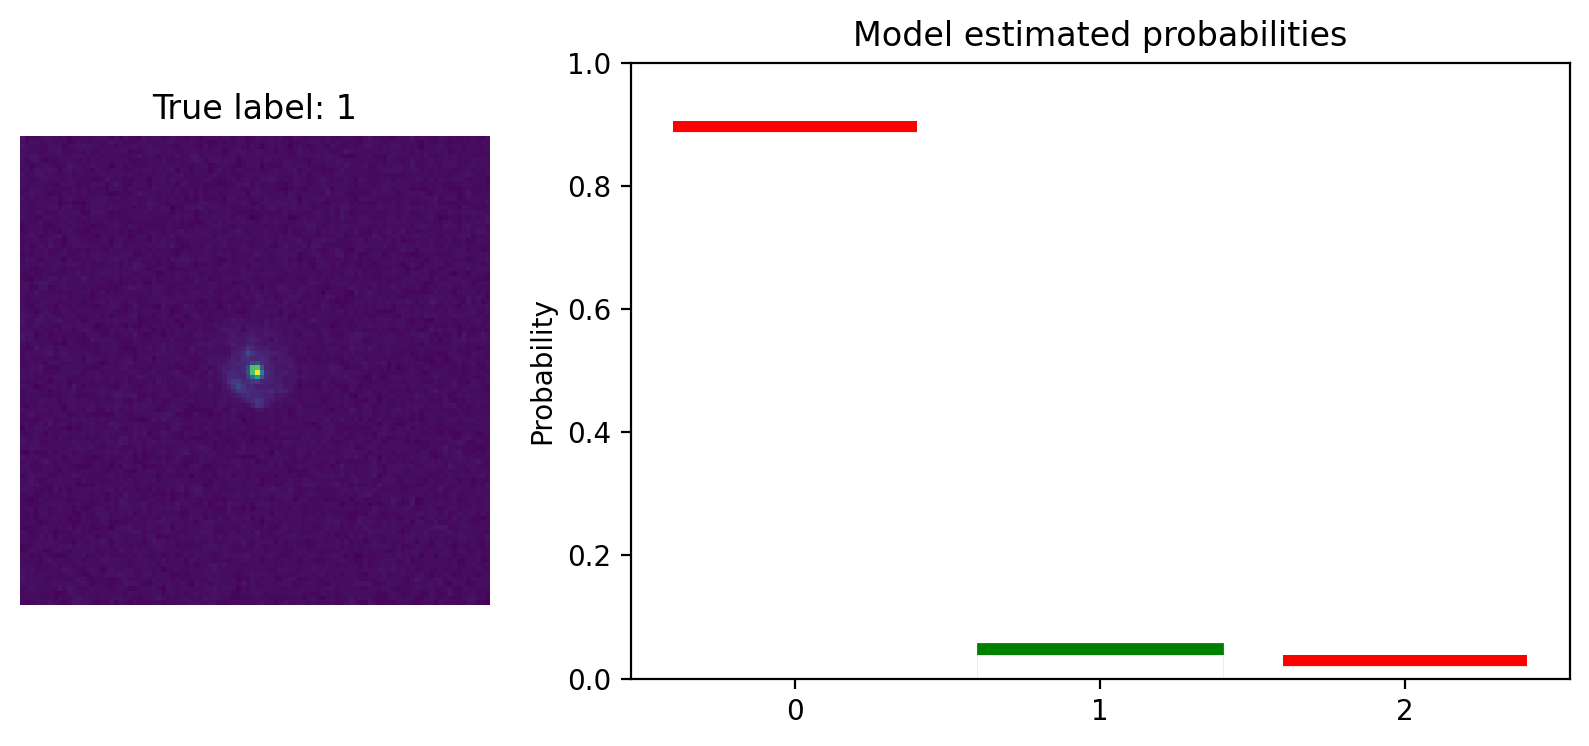

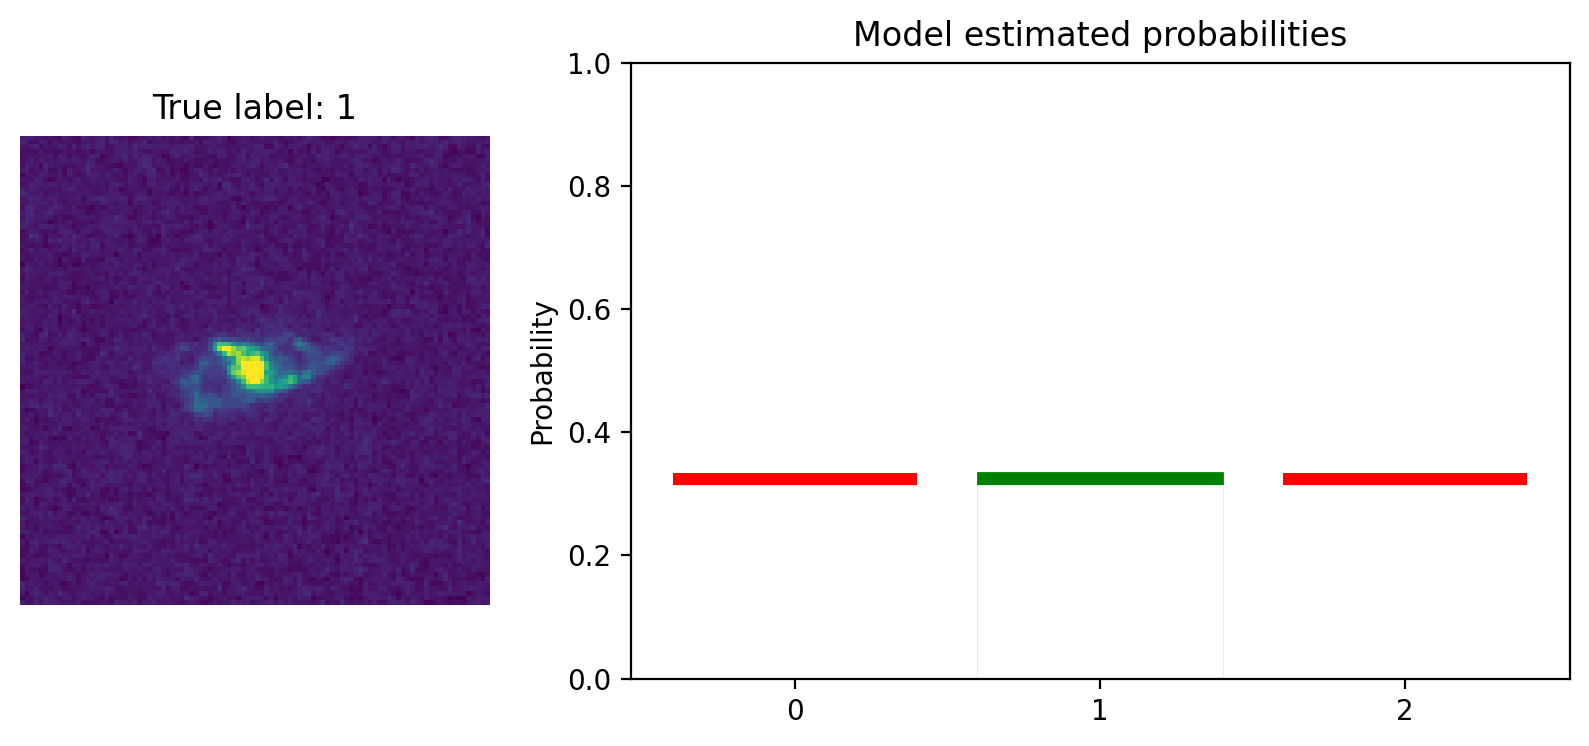

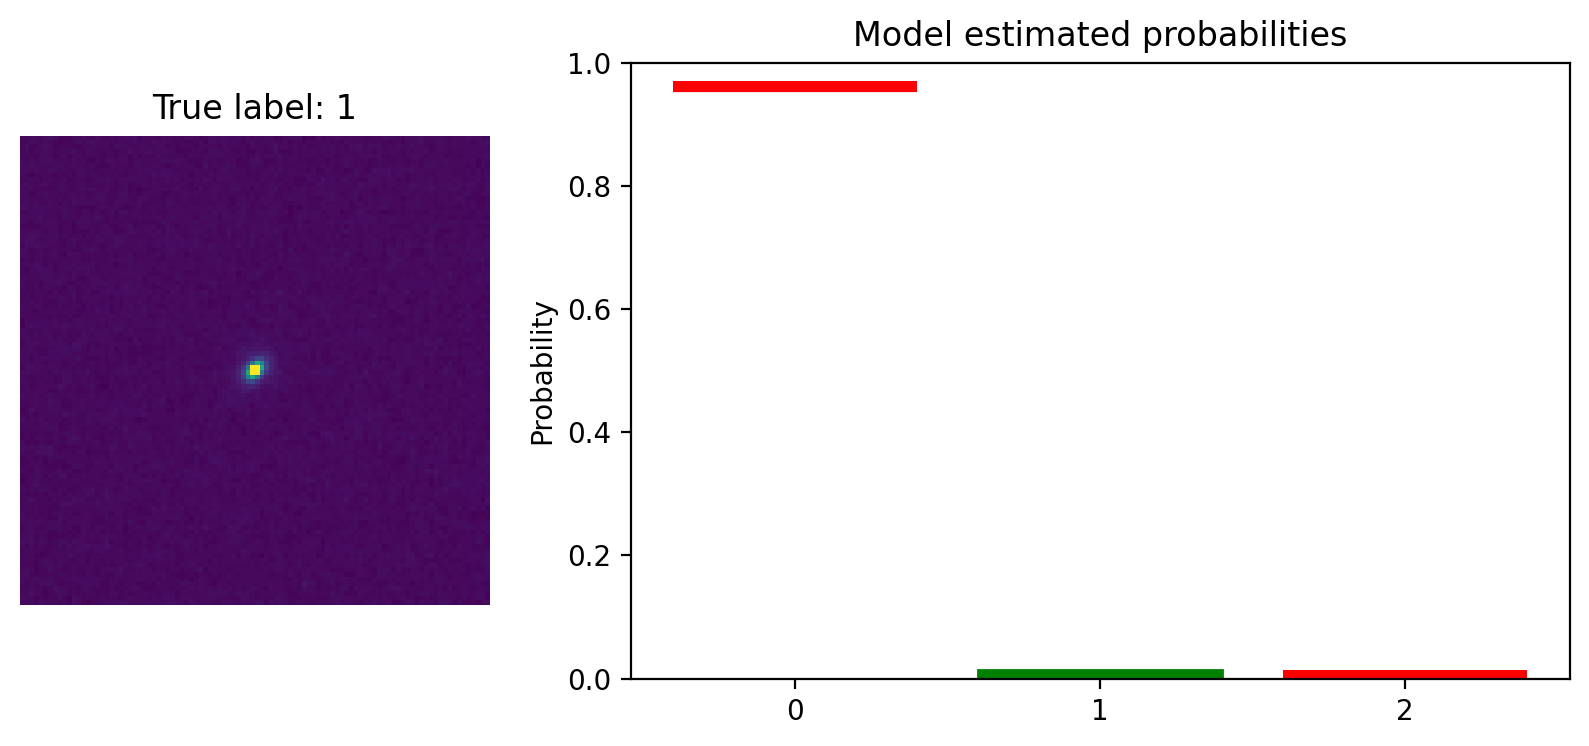

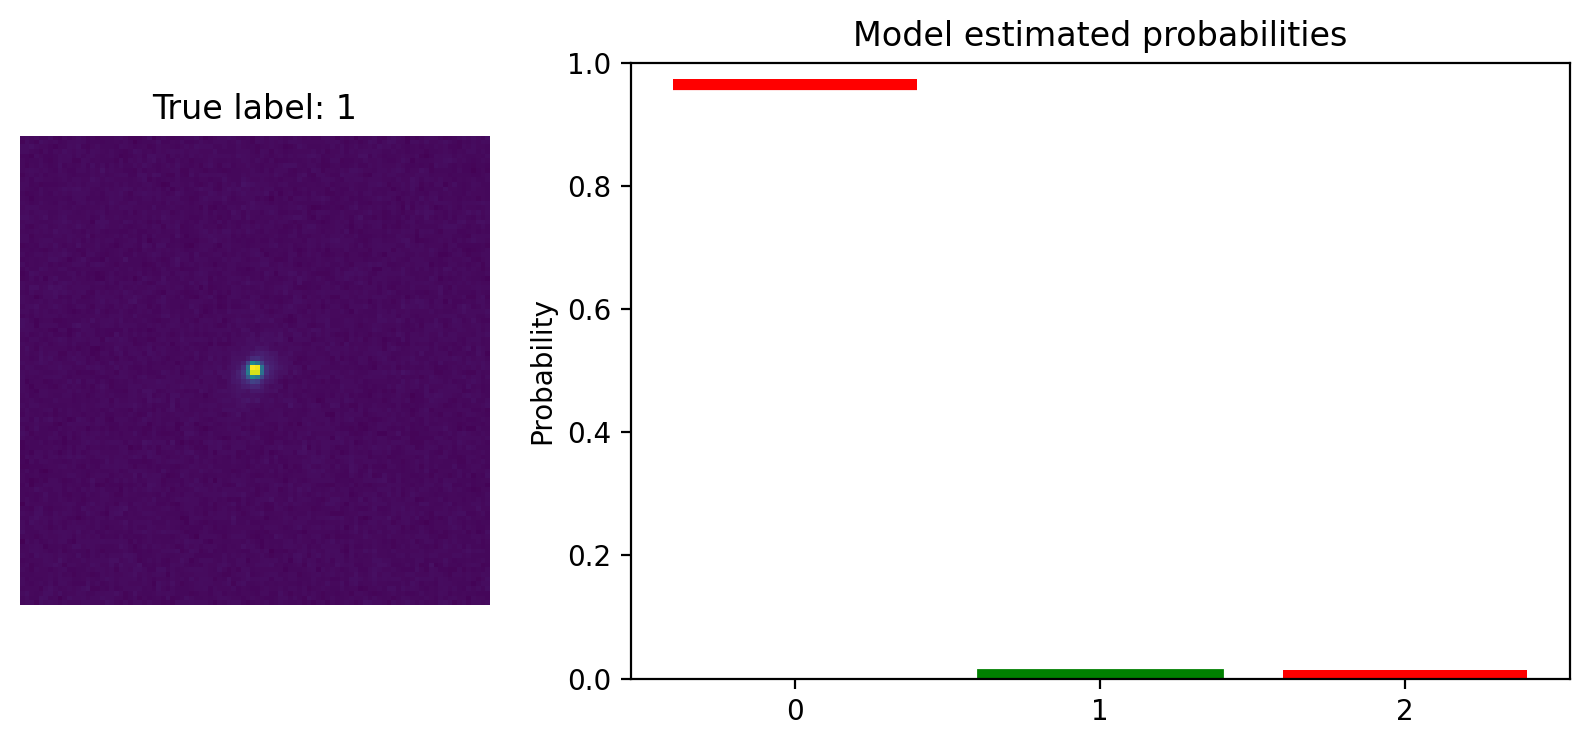

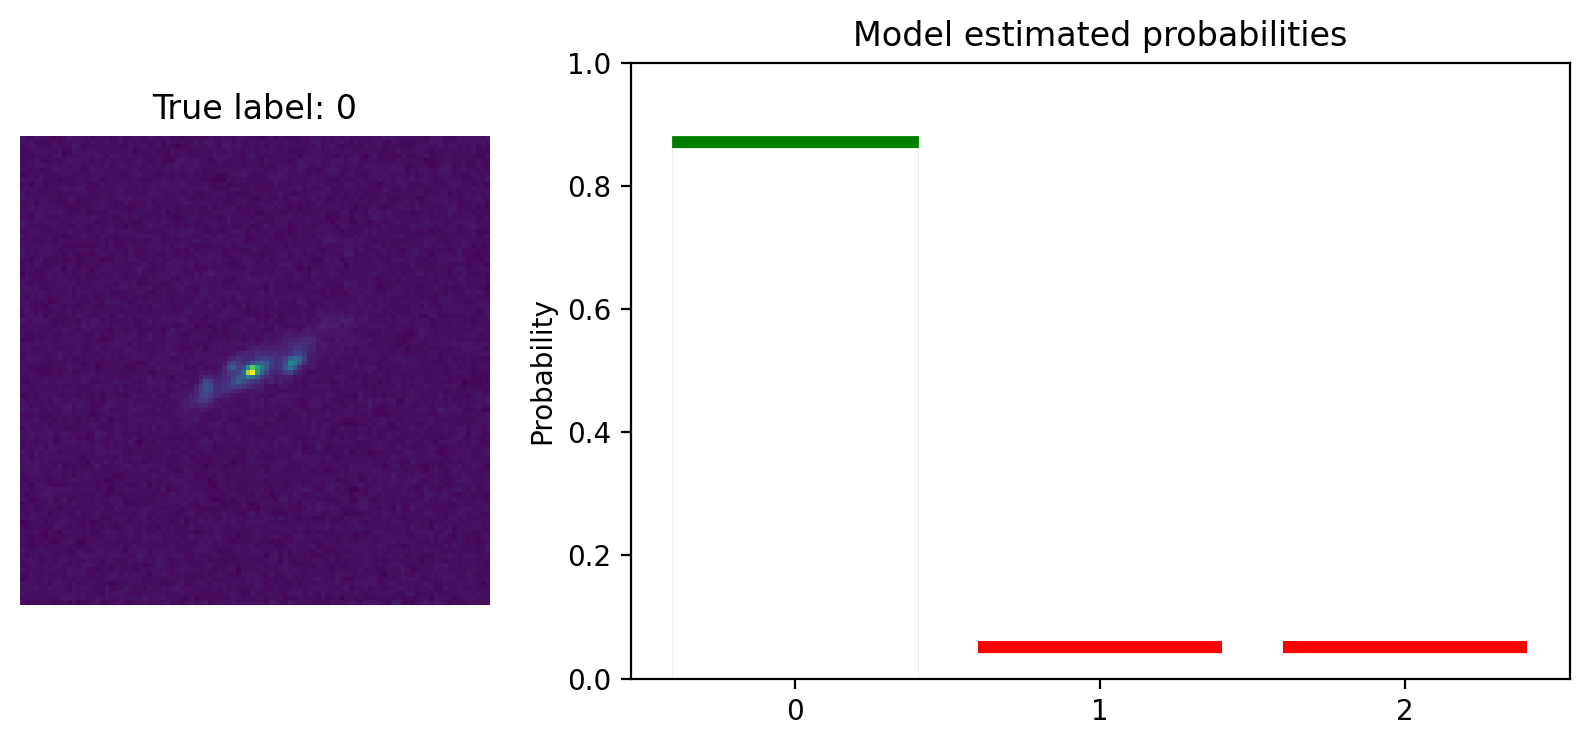

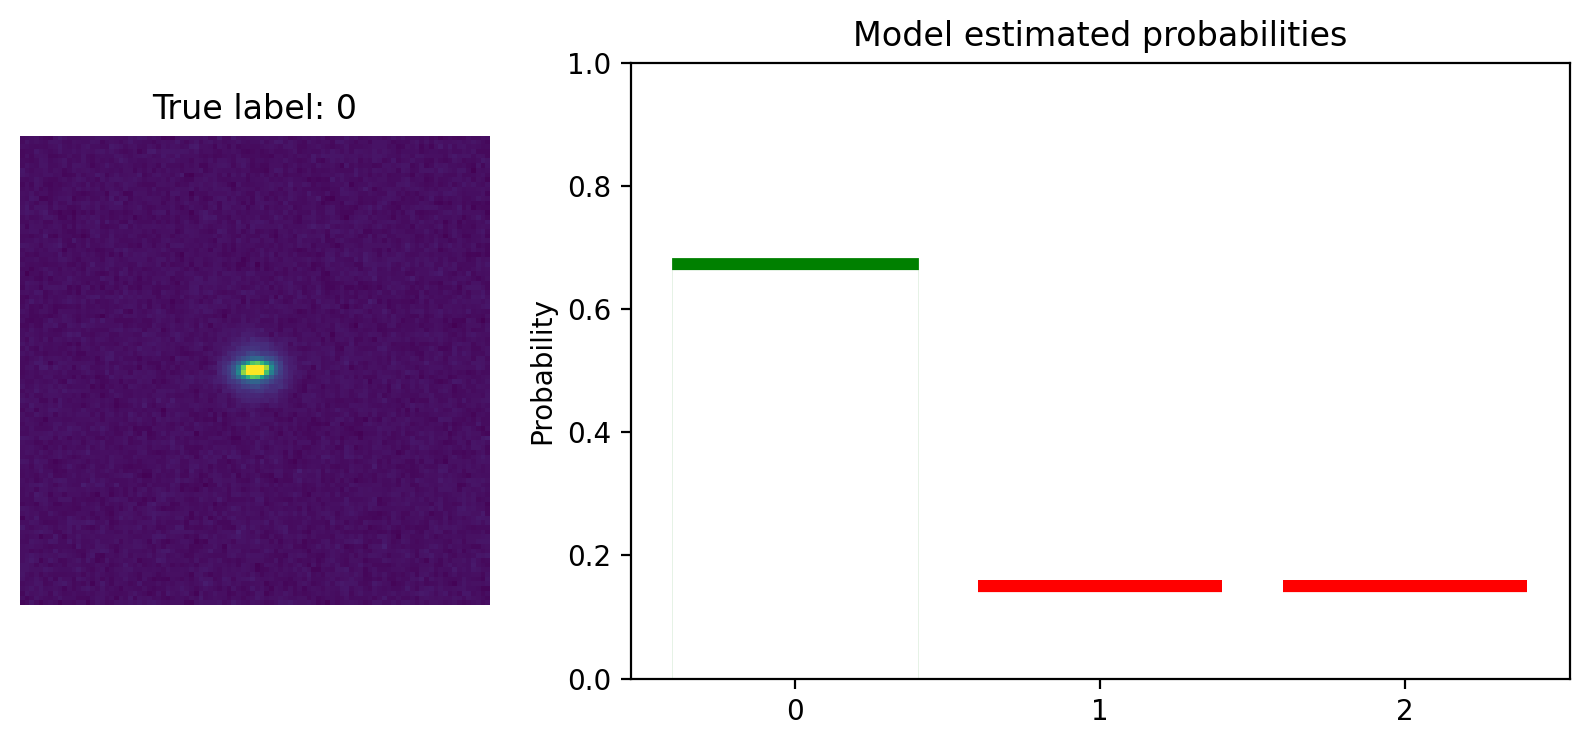

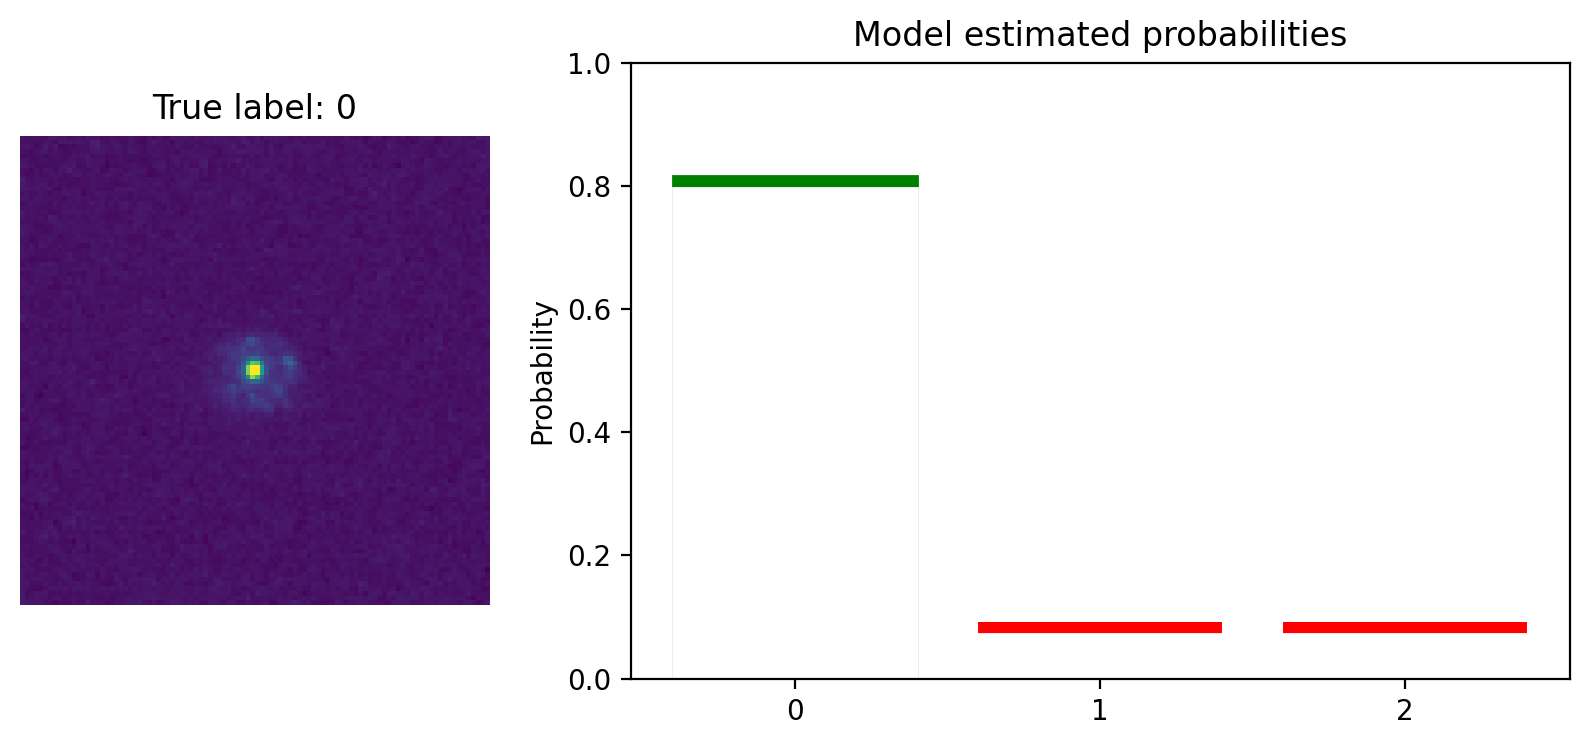

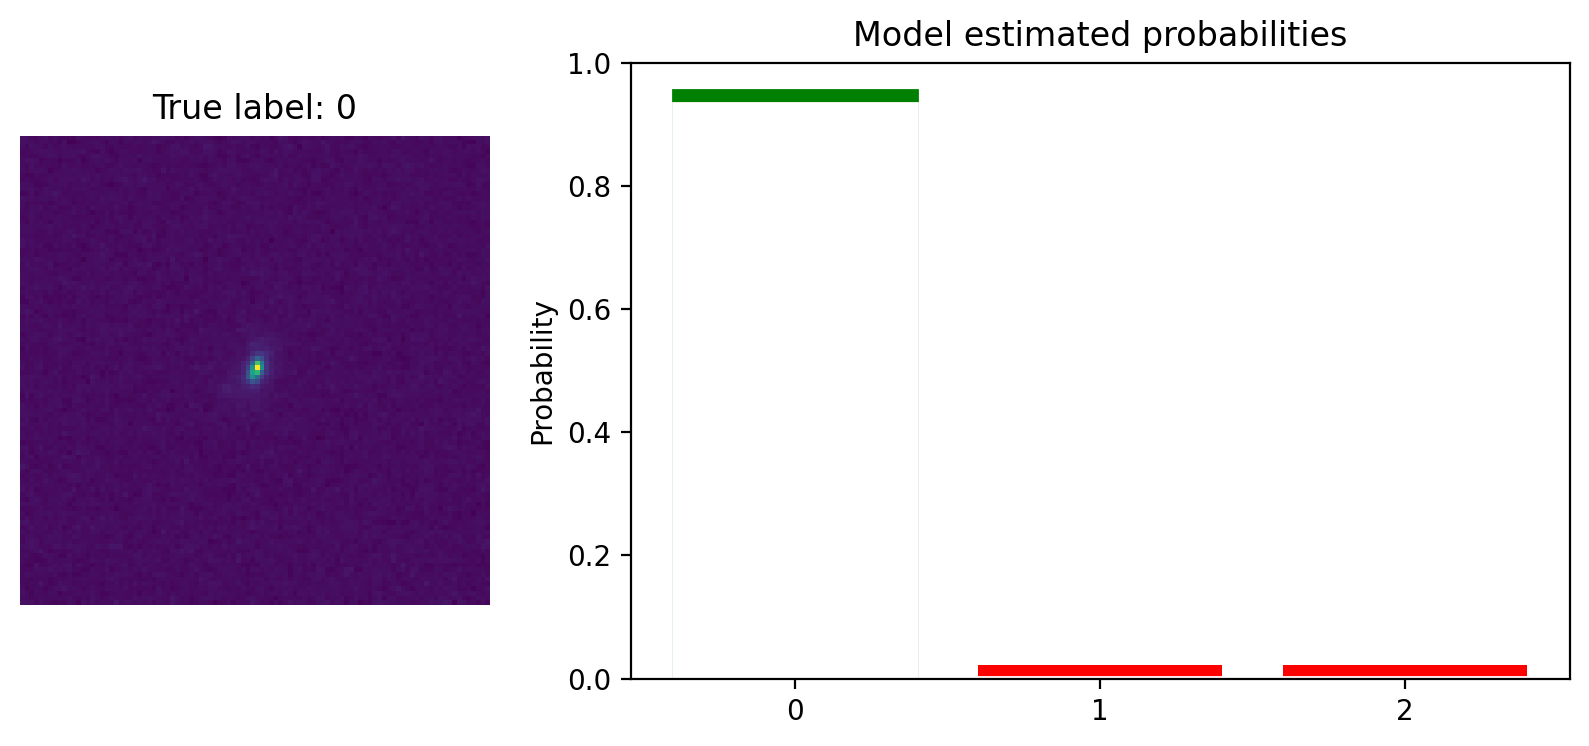

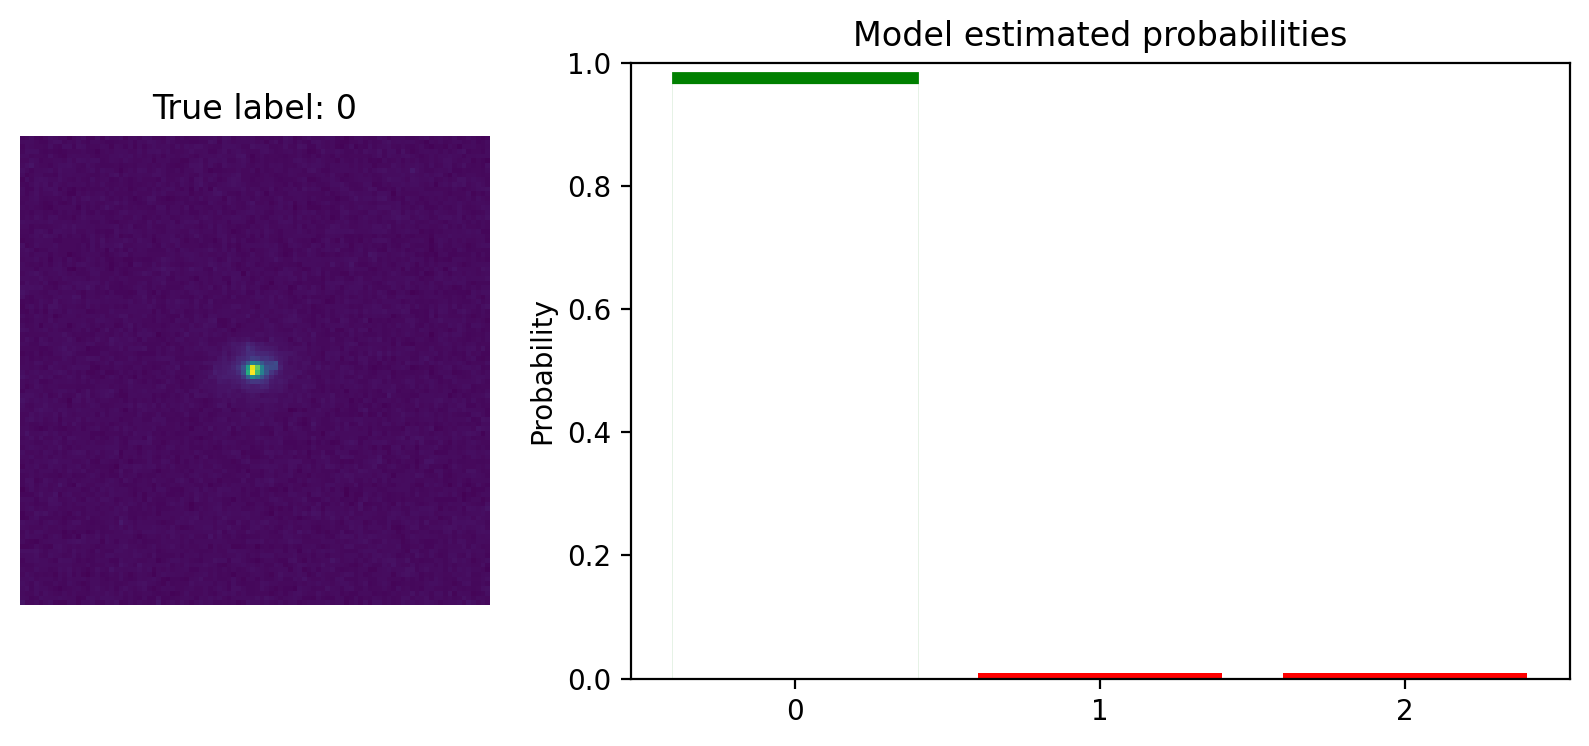

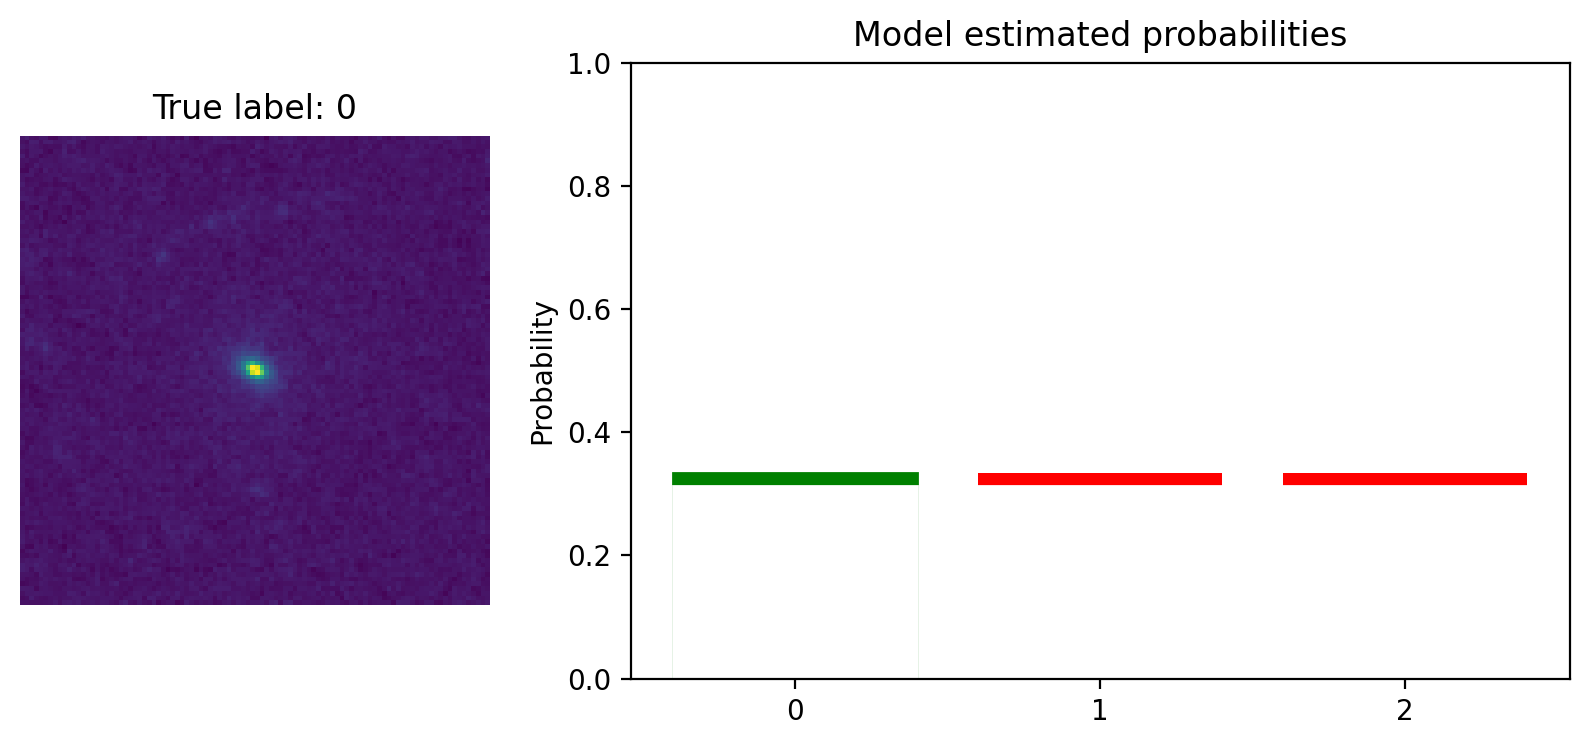

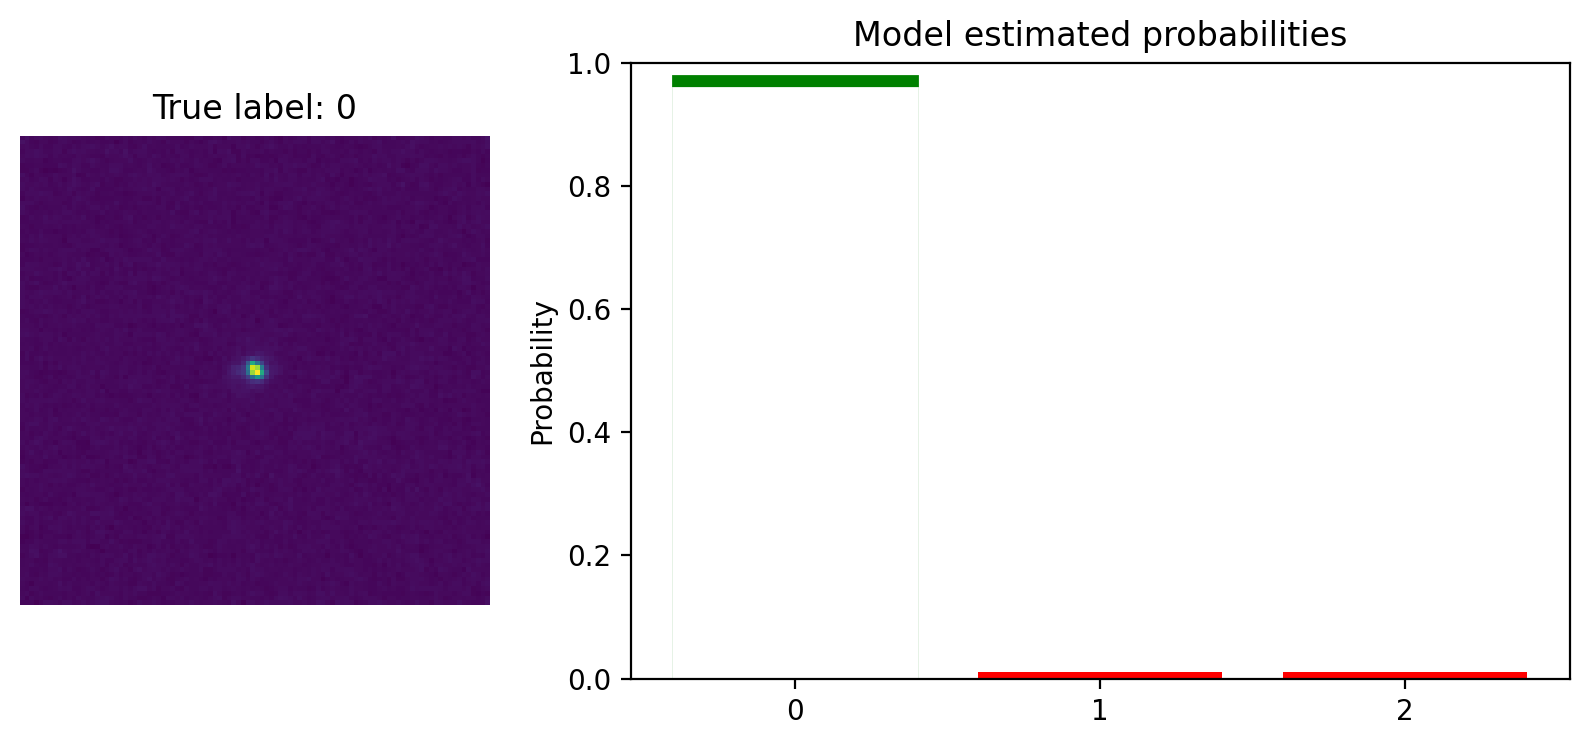

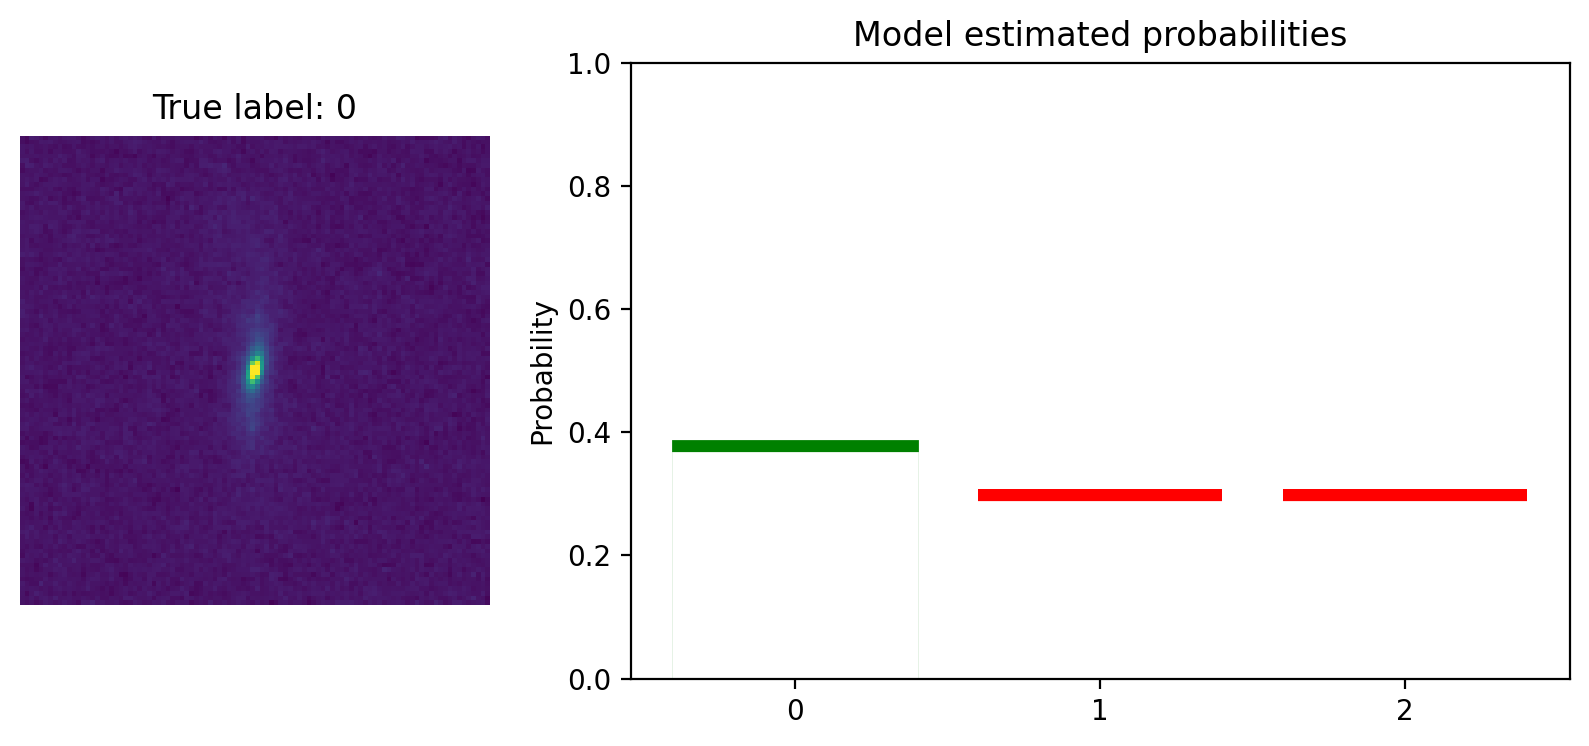

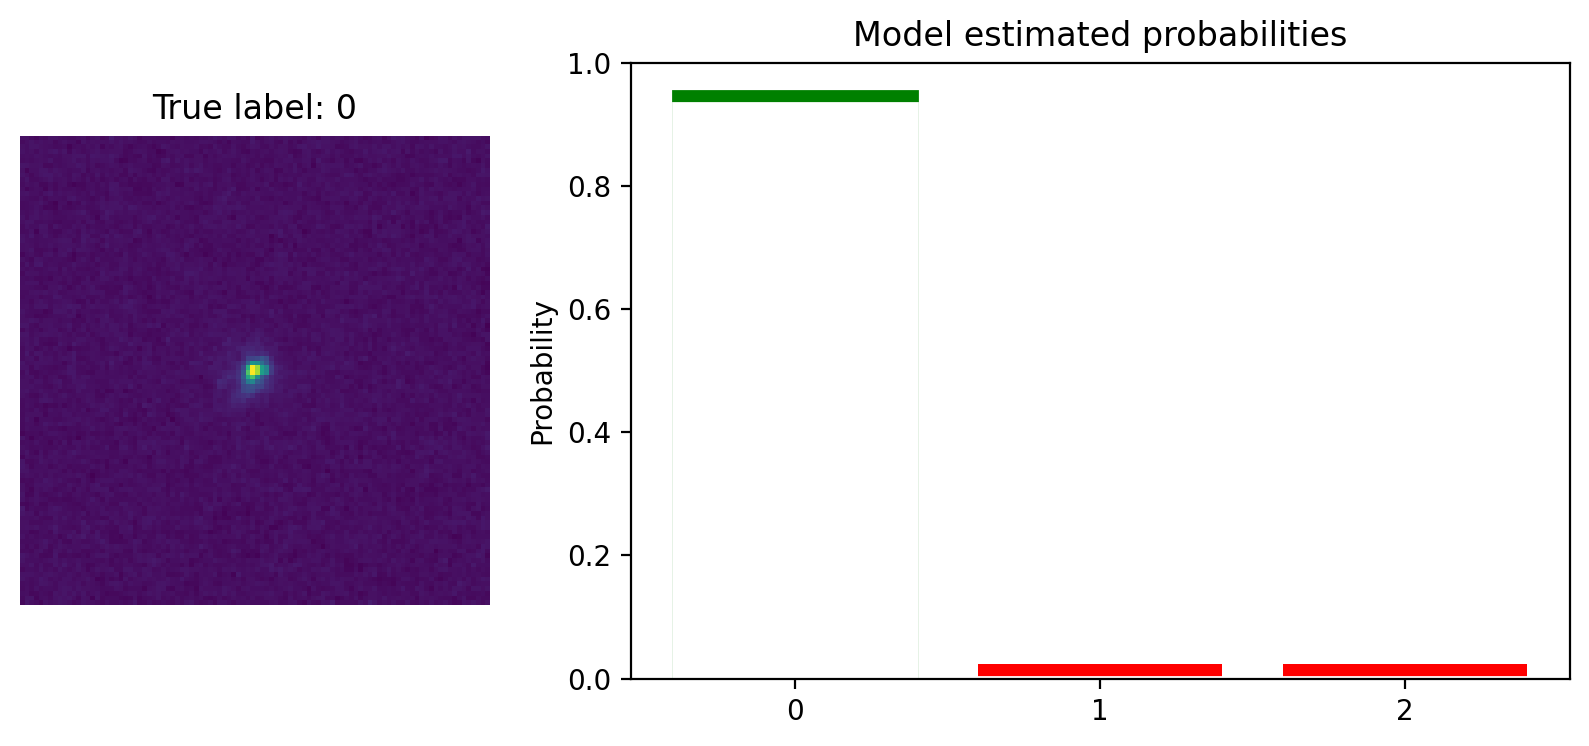

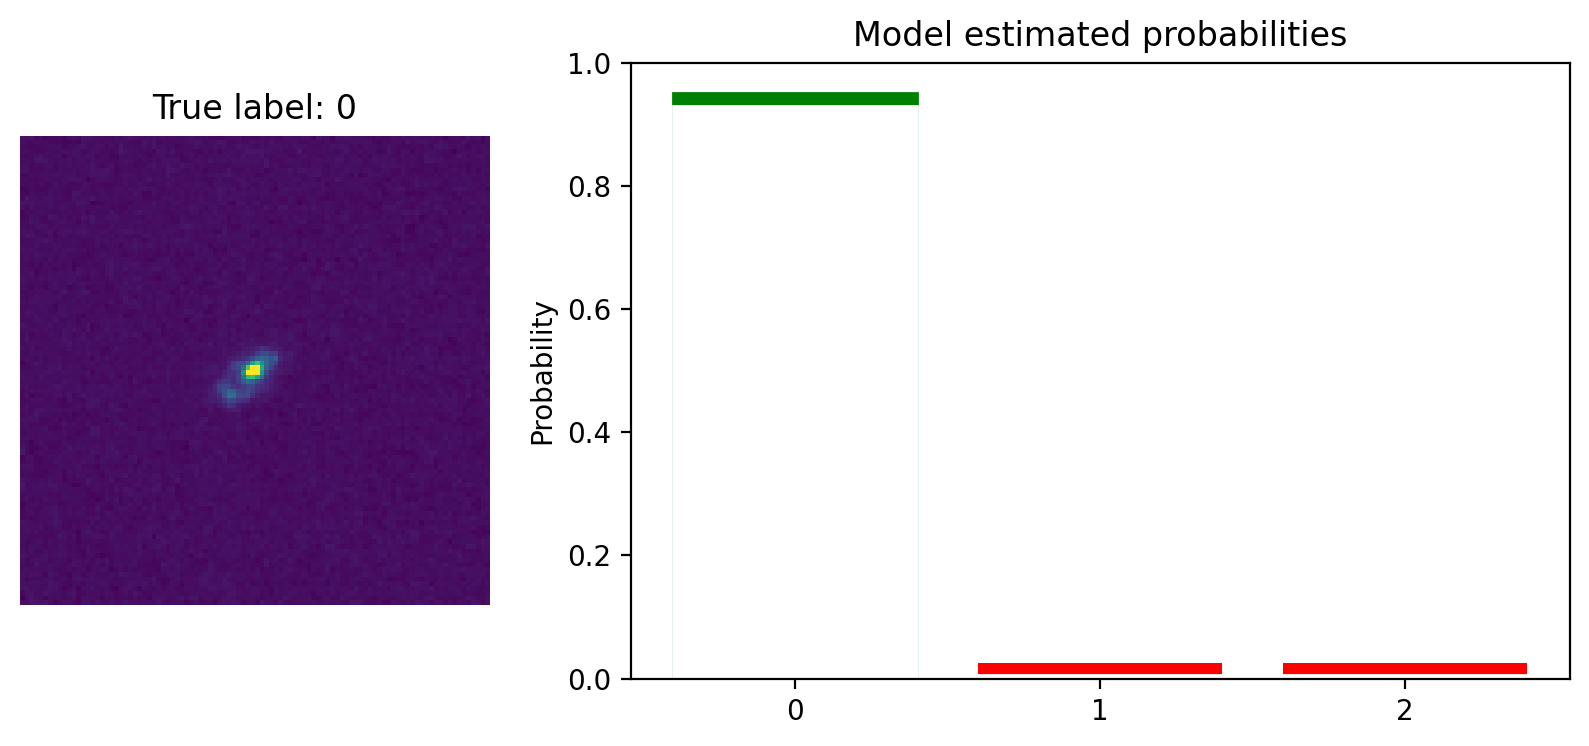

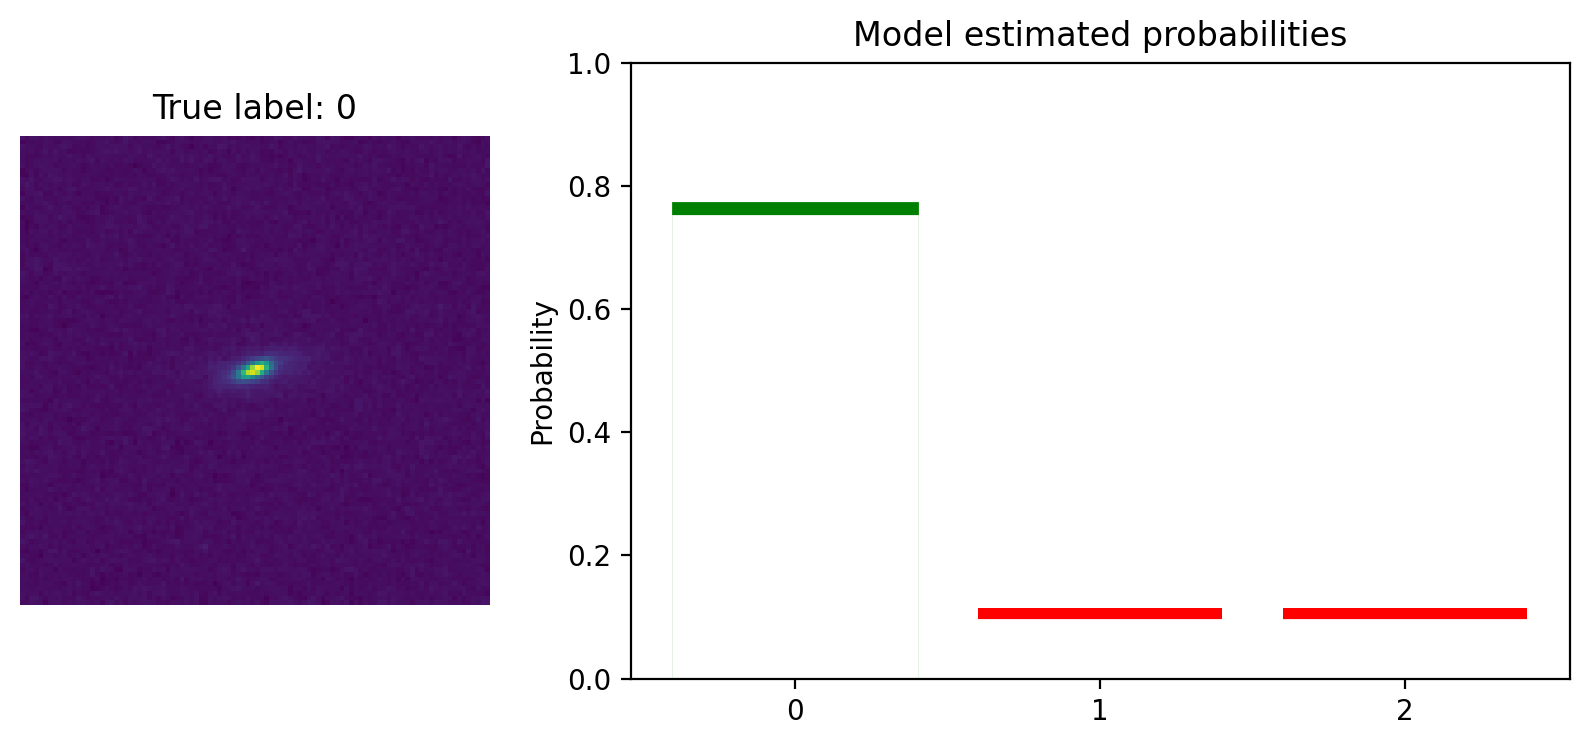

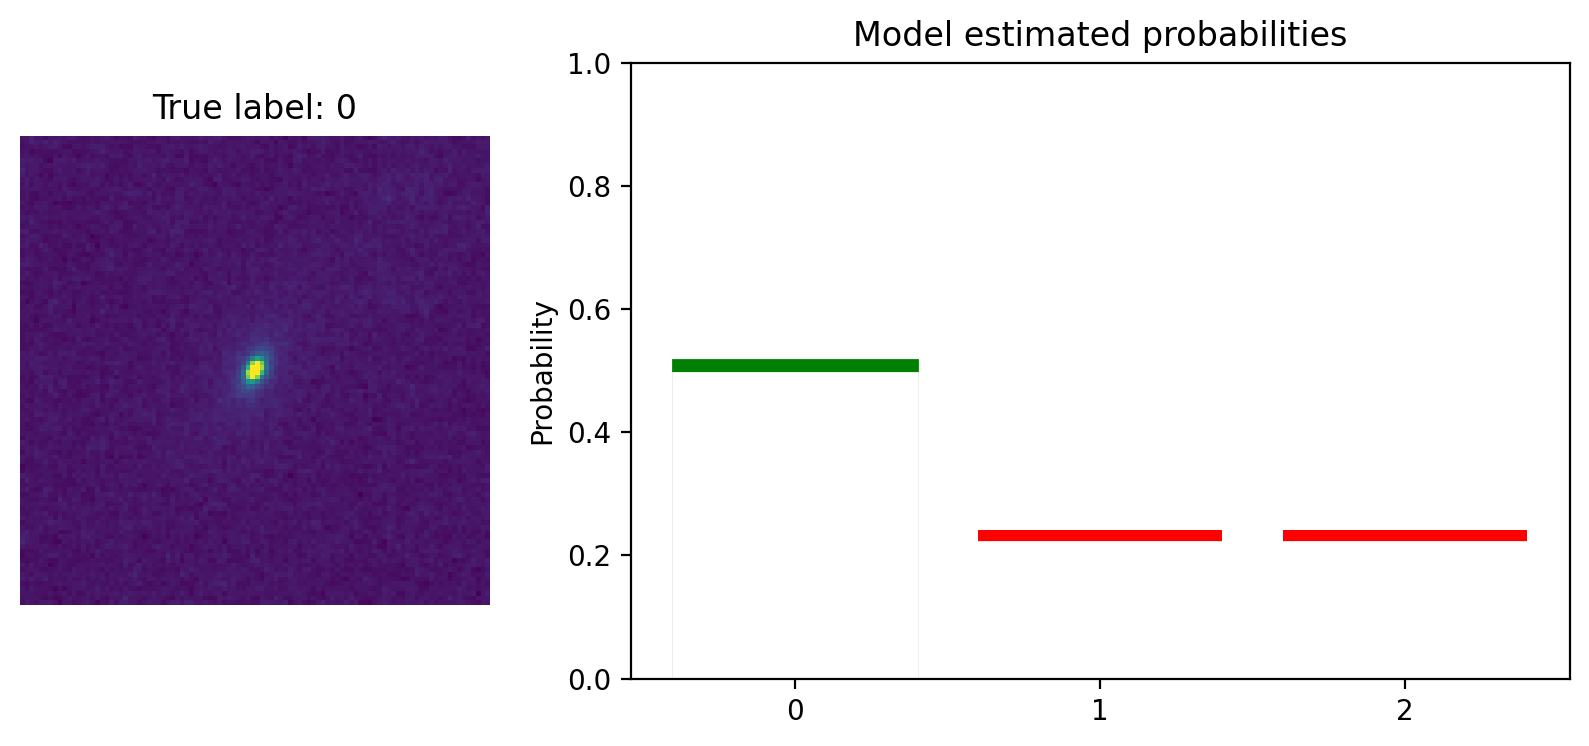

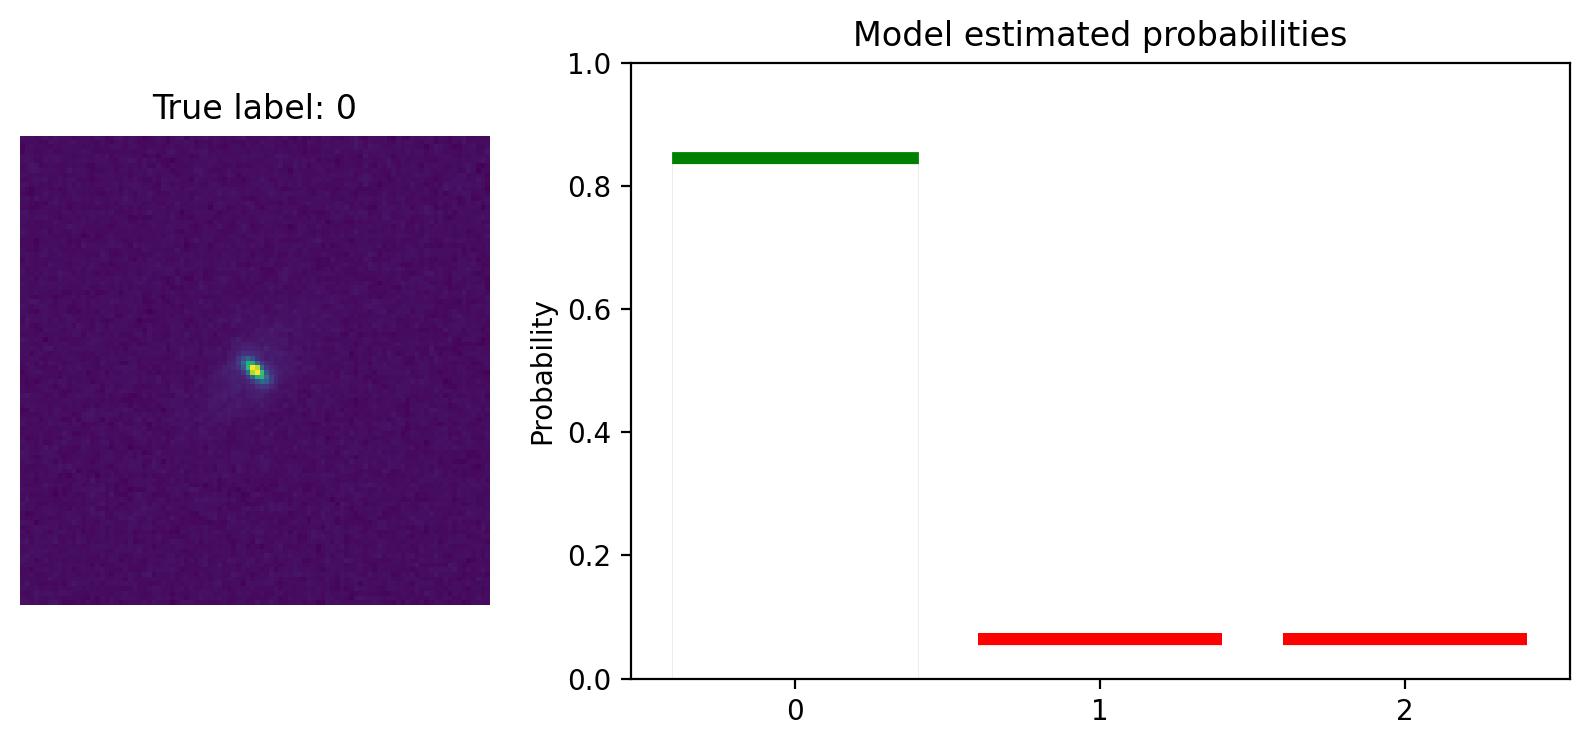

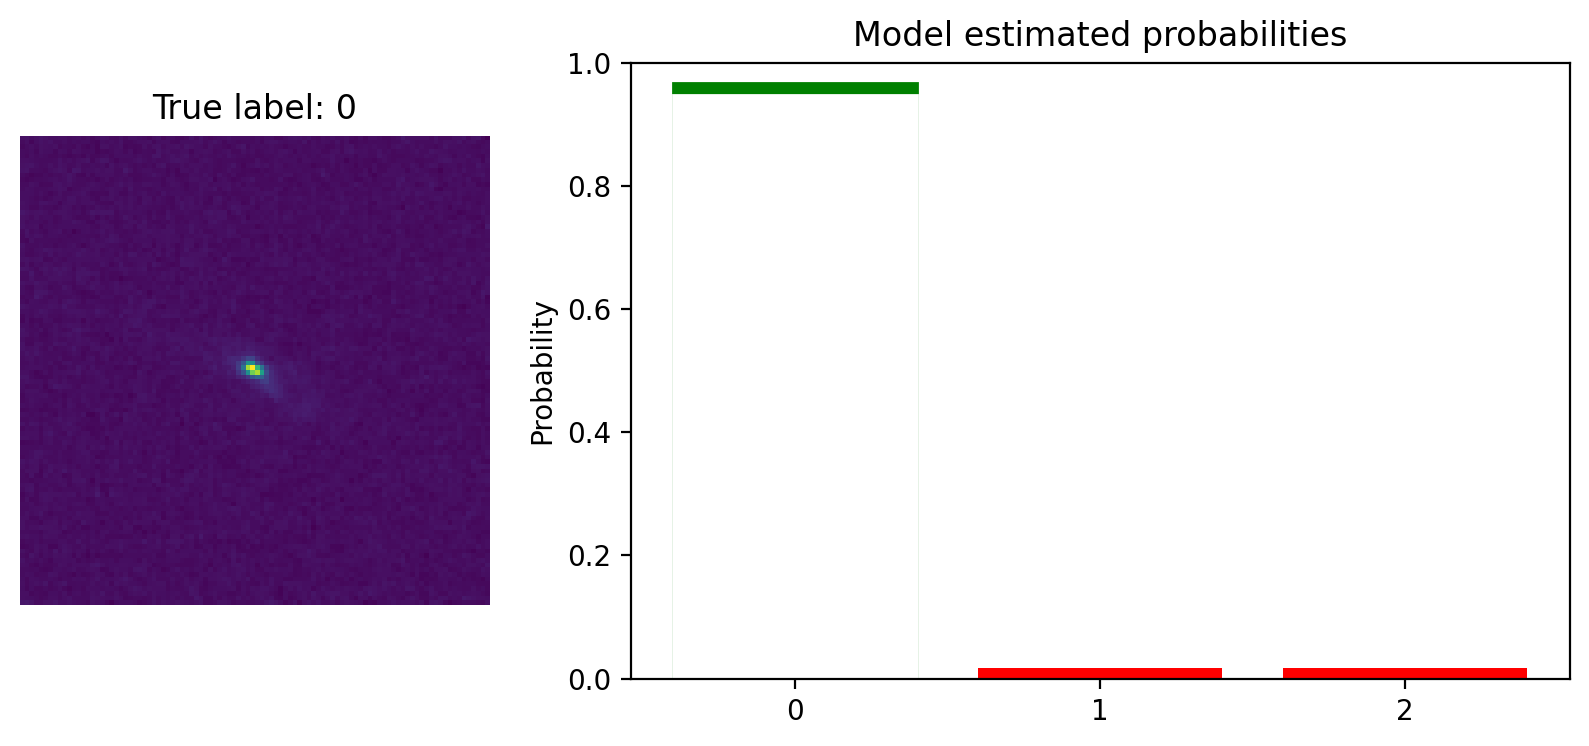

In [61]:
# Evaluate and visualize for Y10 test data
for i in [0, 1000, 1500, 2000, 2500, 2865, 3000, 3300, 
          3500, 3900, 4000, 4500, 5000, 5500, 6000,
          6200, 6400, 6600, 6714]:
    image = X_test_10[i]
    true_label = Y_test[i, 0]
    predicted_probabilities = np.empty(shape=(1, 3))
    
    for i in range(1):
        predicted_probabilities[i] = resnet18_prob_model(image[np.newaxis, :]).mean().numpy()[0]
        
    model_prediction = resnet18_prob_model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[...][0])
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    # make plots of probabilities that the model estimates
    pct_5 = np.array([np.percentile(predicted_probabilities[:, i], 0.5) for i in range(3)])
    pct_95 = np.array([np.percentile(predicted_probabilities[:, i], 95.) for i in range(3)])    
    bar = ax2.bar(np.arange(3), pct_95, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(3), pct_5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(3))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

### Transfer Learning

#### Method 1: Try TL without making previous layers non-trainable

In [ ]:
# Check for trainable and non-trainable variables
print("\n Model has {} trainable variables: {}, ...".format(
          len(resnet18_prob_model.trainable_variables),
          ", ".join([v.name for v in resnet18_prob_model.trainable_variables])))

trainable_variable_ids = {id(v) for v in resnet18_prob_model.trainable_variables}
non_trainable_variables = [v for v in resnet18_prob_model.variables
                           if id(v) not in trainable_variable_ids]
print("\n Model also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables])))

In [ ]:
# Make last layer the output and initialize model
last = resnet18_prob_model.layers[-4].output
x = Dropout(0.5)(last)
x = GlobalAveragePooling2D(name='avgpool')(x)
outputs = Dense(units=NUM_CLASSES, activation="softmax", name='fc')(x)
base_model = Model(inputs = resnet18_prob_model.input, outputs = outputs)

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate = 1e-6)
base_model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
base_model.summary()

In [180]:
## Define Callback Functions
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f" {base_model.name}"

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5), 
      ModelCheckpoint(filepath='resnet18_TL_trainable_best_weights', monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tf.keras.callbacks.TensorBoard(log_dir=log_dir),
      ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=5, factor=0.1)
      ]

In [ ]:
# Train the new layers on the dataset
batch_size = 128
NUM_EPOCH = 200
history_TL_trainable = base_model.fit(X_train_10, Y_train,
                                        batch_size=batch_size,
                                        epochs=NUM_EPOCH,
                                        validation_data=(X_valid_10, Y_valid),
                                        shuffle=True,
                                        verbose=1,
                                        callbacks=es
                                )

In [ ]:
# Save model data
base_model.save(filepath = f'Y1_ResNet18_Dropout_TL_trainable', include_optimizer = True, overwrite = True)
    
# Saving history as .npy file for future use
np.save(f'Y1_ResNet18_Dropout_TL_trainable_history.npy', history_TL_trainable.history)

# Plot training history
acc = history_TL_trainable.history['accuracy']
val_acc = history_TL_trainable.history['val_accuracy']

loss = history_TL_trainable.history['loss']
val_loss = history_TL_trainable.history['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"ResNet18 with Dropout Transfer Learning Trainable Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(fname=f"ResNet18 with Dropout Transfer Learning Trainable Accuracy Training History", format='jpg')
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"ResNet18 with Dropout Transfer Learning Trainable Loss Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(fname=f"ResNet18 with Dropout Transfer Learning Trainable Loss Training History", format='jpg')
plt.show()

In [ ]:
# Re-test model on Y10 test set 
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = base_model.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(base_model.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('ResNet18 Transfer Learning Trainable Y10 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_TL_Trainable_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 Transfer Learning Trainable Test ROC Curves')
plt.savefig('Y10_ResNet18_TL_Trainable_test_ROC')
plt.show()

In [ ]:
# Re-test model on Y10 test set 
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = base_model.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(base_model.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('ResNet18 Transfer Learning Trainable Y10 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y10_ResNet18_TL_Trainable_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 Transfer Learning Trainable Test ROC Curves')
plt.savefig('Y10_ResNet18_TL_Trainable_test_ROC')
plt.show()

In [ ]:
# Re-test model on Y1 test set 
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = base_model.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(base_model.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('ResNet18 Transfer Learning Trainable Y1 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_TL_Trainable_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 Transfer Learning Trainable Test ROC Curves')
plt.savefig('Y1_ResNet18_TL_Trainable_test_ROC')
plt.show()

#### Method 2: Try TL and make all previous layers non-trainable

## Bayesian Neural Network

#### Setup

In [11]:
# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn
kl_divergence_function = lambda q, p, _: tfd.kl_divergence(q, p) / X_train_1.shape[0]

In [12]:
# ResNet18 w/ Dropout
def conv3x3_bnn(x, out_planes, stride=1, name=None):
    x = ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return tfp.layers.Convolution2DReparameterization(filters=out_planes,
                                                        kernel_size=3, 
                                                        strides=stride, 
                                                        kernel_divergence_fn=kl_divergence_function, 
                                                        name=name)(x)

def basic_block_bnn(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3_bnn(x, planes, stride=stride, name=f'{name}.conv1')
    out = BatchNormalization(name=f'{name}.bn1')(out)
    out = Activation('relu', name=f'{name}.relu1')(out)

    out = conv3x3_bnn(out, planes, name=f'{name}.conv2')
    out = BatchNormalization(name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = Add(name=f'{name}.add')([identity, out])
    out = Activation('relu', name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [tfp.layers.Convolution2DReparameterization(filters=planes, 
                                                                kernel_size=1,
                                                                strides=stride, 
                                                                kernel_divergence_fn = kl_divergence_function,
                                                                name=f'{name}.0.downsample.0'),
                      BatchNormalization(name=f'{name}.0.downsample.1')
                      ]

    x = basic_block_bnn(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block_bnn(x, planes, name=f'{name}.{i}')

    return x

def resnet_bnn(x, blocks_per_layer, num_classes=NUM_CLASSES):
    x = ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = tfp.layers.Convolution2DReparameterization(filters=64, 
                                                    kernel_size=7,
                                                    strides=2, name='conv1', 
                                                    kernel_divergence_fn = kl_divergence_function)(x)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D(name='avgpool')(x)
    # Create hidden layers with weight uncertainty using the DenseFlipout layer
    # Produces the parameters of the distribution
    distribution_params = tfp.layers.DenseReparameterization(units=num_classes,
                                                              activation="relu",
                                                              kernel_divergence_fn=kl_divergence_function,
                                                              name='fc')(x)
    # Output is a distribution object (OneHotCategorical), used for multiple classes
    outputs = tfp.layers.OneHotCategorical(num_classes)(distribution_params)

    return outputs

def resnet18_bnn(x, **kwargs):
    return resnet_bnn(x, [2, 2, 2, 2], **kwargs)

In [13]:
# Initialize Bayesian model for 3 classes
inputs = Input(shape = (3, 100, 100))
outputs = resnet18_bnn(inputs)
bayesian_resnet18_model = Model(inputs, outputs)

## Compile Model
loss = CategoricalCrossentropy(from_logits=True)
optimizer = Adam()
bayesian_resnet18_model.compile(optimizer = optimizer, loss = nll, metrics = ['accuracy'])
bayesian_resnet18_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 9, 106, 100)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2DReparameterizatio  (None, 2, 50, 64)   627264      ['conv1_pad[0][0]']              
 n)                                                                                               
                                                                                              

#### Train

In [14]:
## Define Callback Functions
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f" {bayesian_resnet18_model.name}"

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10), 
      ModelCheckpoint(filepath='bnn_resnet18_best_weights', monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tf.keras.callbacks.TensorBoard(log_dir=log_dir),
      ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=5, factor=0.1)
      ]

In [15]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [16]:
# Train Bayesian Neural Network
batch_size = 256
NUM_EPOCH = 200
history_resnet18_BNN = bayesian_resnet18_model.fit(X_train_1, Y_train,
                                                    batch_size = batch_size,
                                                    epochs = NUM_EPOCH,              
                                                    validation_data = (X_valid_1, Y_valid),
                                                    shuffle = True,
                                                    class_weight = class_weights,
                                                    verbose = 1,
                                                    callbacks = es
                                                    )

# Save bayesian model data
json_config = bayesian_resnet18_model.to_json()
bayesian_resnet18_model.save(filepath = f'Y1_ResNet18_Dropout_BNN', 
                             include_optimizer = True, overwrite = True)

# Saving history as .npy file for future use
np.save(f'Y1_ResNet18_Dropout_BNN_history.npy', history_resnet18_BNN.history)

Epoch 1/200


2023-04-12 16:12:19.152213: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-12 16:12:19.693752: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


92/92 [==============================] - ETA: 0s - loss: 1216.6218 - accuracy: 0.3340
Epoch 1: val_accuracy improved from -inf to 0.34188, saving model to bnn_resnet18_best_weights


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


92/92 [==============================] - 74s 739ms/step - loss: 1216.6218 - accuracy: 0.3340 - val_loss: 1195.0692 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 2/200
92/92 [==============================] - ETA: 0s - loss: 1174.1226 - accuracy: 0.3332
Epoch 2: val_accuracy did not improve from 0.34188
92/92 [==============================] - 42s 456ms/step - loss: 1174.1226 - accuracy: 0.3332 - val_loss: 1152.6251 - val_accuracy: 0.3306 - lr: 0.0010
Epoch 3/200
92/92 [==============================] - ETA: 0s - loss: 1131.7411 - accuracy: 0.3345
Epoch 3: val_accuracy did not improve from 0.34188
92/92 [==============================] - 41s 444ms/step - loss: 1131.7411 - accuracy: 0.3345 - val_loss: 1110.2949 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 4/200
92/92 [==============================] - ETA: 0s - loss: 1089.4565 - accuracy: 0.3374
Epoch 4: val_accuracy did not improve from 0.34188
92/92 [==============================] - 42s 452ms/step - loss: 1089.4565 - accuracy: 0.3374 - val_l

INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


92/92 [==============================] - 64s 695ms/step - loss: 57.8026 - accuracy: 0.3379 - val_loss: 53.0500 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 39/200
92/92 [==============================] - ETA: 0s - loss: 48.8295 - accuracy: 0.3366
Epoch 39: val_accuracy did not improve from 0.34575
92/92 [==============================] - 40s 440ms/step - loss: 48.8295 - accuracy: 0.3366 - val_loss: 44.6925 - val_accuracy: 0.3365 - lr: 0.0010
Epoch 40/200
92/92 [==============================] - ETA: 0s - loss: 41.0322 - accuracy: 0.3317
Epoch 40: val_accuracy did not improve from 0.34575
92/92 [==============================] - 41s 443ms/step - loss: 41.0322 - accuracy: 0.3317 - val_loss: 37.4528 - val_accuracy: 0.3344 - lr: 0.0010
Epoch 41/200
92/92 [==============================] - ETA: 0s - loss: 34.3241 - accuracy: 0.3341
Epoch 41: val_accuracy did not improve from 0.34575
92/92 [==============================] - 40s 434ms/step - loss: 34.3241 - accuracy: 0.3341 - val_loss: 31.2831 -

INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


92/92 [==============================] - 62s 672ms/step - loss: 2.7897 - accuracy: 0.3315 - val_loss: 2.7441 - val_accuracy: 0.3463 - lr: 0.0010
Epoch 66/200
92/92 [==============================] - ETA: 0s - loss: 2.7005 - accuracy: 0.3326
Epoch 66: val_accuracy did not improve from 0.34635
92/92 [==============================] - 42s 452ms/step - loss: 2.7005 - accuracy: 0.3326 - val_loss: 2.6566 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 67/200
92/92 [==============================] - ETA: 0s - loss: 2.6333 - accuracy: 0.3286
Epoch 67: val_accuracy did not improve from 0.34635
92/92 [==============================] - 44s 475ms/step - loss: 2.6333 - accuracy: 0.3286 - val_loss: 2.5960 - val_accuracy: 0.3174 - lr: 0.0010
Epoch 68/200
92/92 [==============================] - ETA: 0s - loss: 2.5578 - accuracy: 0.3305
Epoch 68: val_accuracy did not improve from 0.34635
92/92 [==============================] - 41s 447ms/step - loss: 2.5578 - accuracy: 0.3305 - val_loss: 2.5199 - val_accura

INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


92/92 [==============================] - 63s 689ms/step - loss: 1.9113 - accuracy: 0.3292 - val_loss: 1.9041 - val_accuracy: 0.3541 - lr: 0.0010
Epoch 82/200
92/92 [==============================] - ETA: 0s - loss: 1.8847 - accuracy: 0.3329
Epoch 82: val_accuracy did not improve from 0.35410
92/92 [==============================] - 40s 437ms/step - loss: 1.8847 - accuracy: 0.3329 - val_loss: 1.8634 - val_accuracy: 0.3383 - lr: 0.0010
Epoch 83/200
92/92 [==============================] - ETA: 0s - loss: 1.8463 - accuracy: 0.3298
Epoch 83: val_accuracy did not improve from 0.35410
92/92 [==============================] - 42s 461ms/step - loss: 1.8463 - accuracy: 0.3298 - val_loss: 1.8301 - val_accuracy: 0.3308 - lr: 0.0010
Epoch 84/200
92/92 [==============================] - ETA: 0s - loss: 1.8170 - accuracy: 0.3344
Epoch 84: val_accuracy did not improve from 0.35410
92/92 [==============================] - 42s 452ms/step - loss: 1.8170 - accuracy: 0.3344 - val_loss: 1.8122 - val_accura

INFO:tensorflow:Assets written to: Y1_ResNet18_Dropout_BNN/assets


INFO:tensorflow:Assets written to: Y1_ResNet18_Dropout_BNN/assets


In [ ]:
%tensorboard --logdir logs/fit

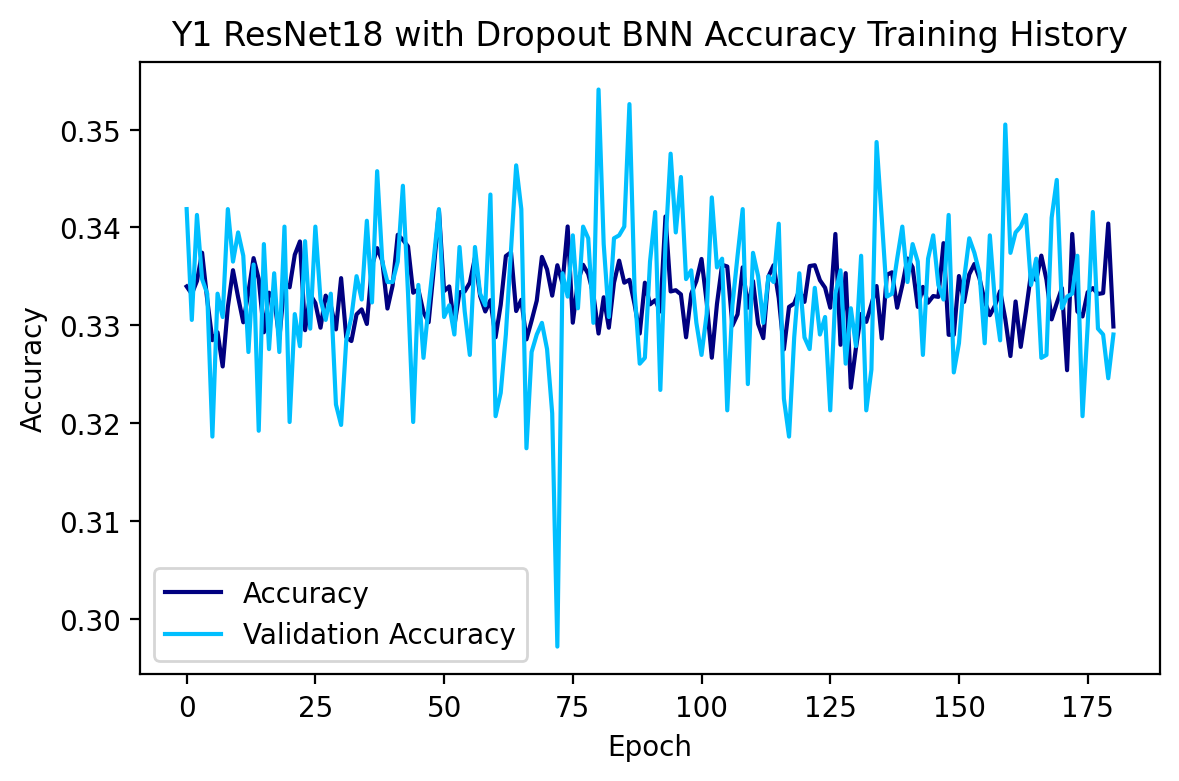

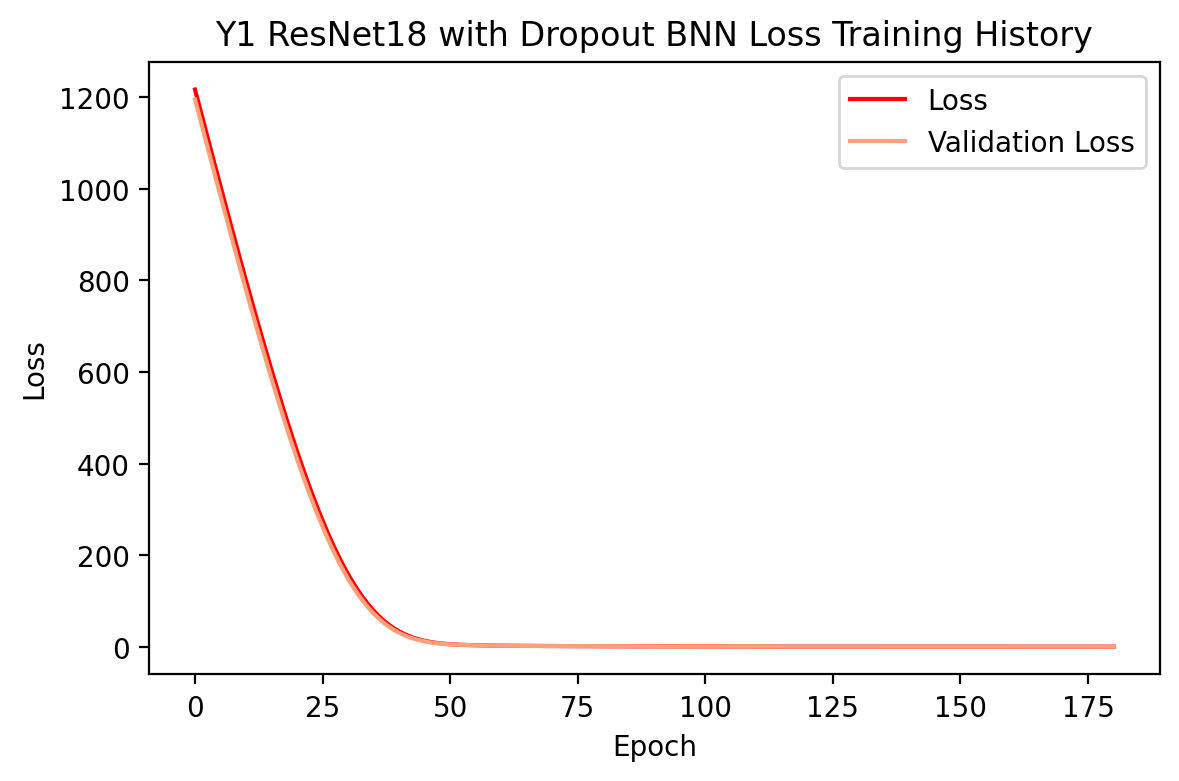

In [18]:
#history_resnet18_BNN = np.load('Y1_ResNet18_Dropout_', allow_pickle=True).item()

# Plot bayesian model training history
acc = history_resnet18_BNN.history['accuracy']
val_acc = history_resnet18_BNN.history['val_accuracy']

loss = history_resnet18_BNN.history['loss']
val_loss = history_resnet18_BNN.history['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Y1 ResNet18 with Dropout BNN Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 with Dropout BNN Accuracy Training History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Y1 ResNet18 with Dropout BNN Loss Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 with Dropout BNN Loss Training History")
plt.show()

#### Evaluate

In [40]:
bnn_model = load_model('Y1_ResNet18_Dropout_BNN', compile=False)
bnn_model.load_weights('bnn_resnet18_best_weights')

2023-04-14 18:43:16.903909: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open bnn_resnet18_best_weights: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


In [ ]:
models_result = np.array([bnn_model.predict(X_test_1) for k in range(len(Y_test))])

210/210 [==============================] - 9s 38ms/step
Y1 Test:
              precision    recall  f1-score   support

      Spiral       0.42      0.33      0.37      2863
  Elliptical       0.24      0.32      0.28      1631
      Merger       0.33      0.34      0.34      2221

    accuracy                           0.33      6715
   macro avg       0.33      0.33      0.33      6715
weighted avg       0.35      0.33      0.34      6715


210/210 [==============================] - 8s 37ms/step


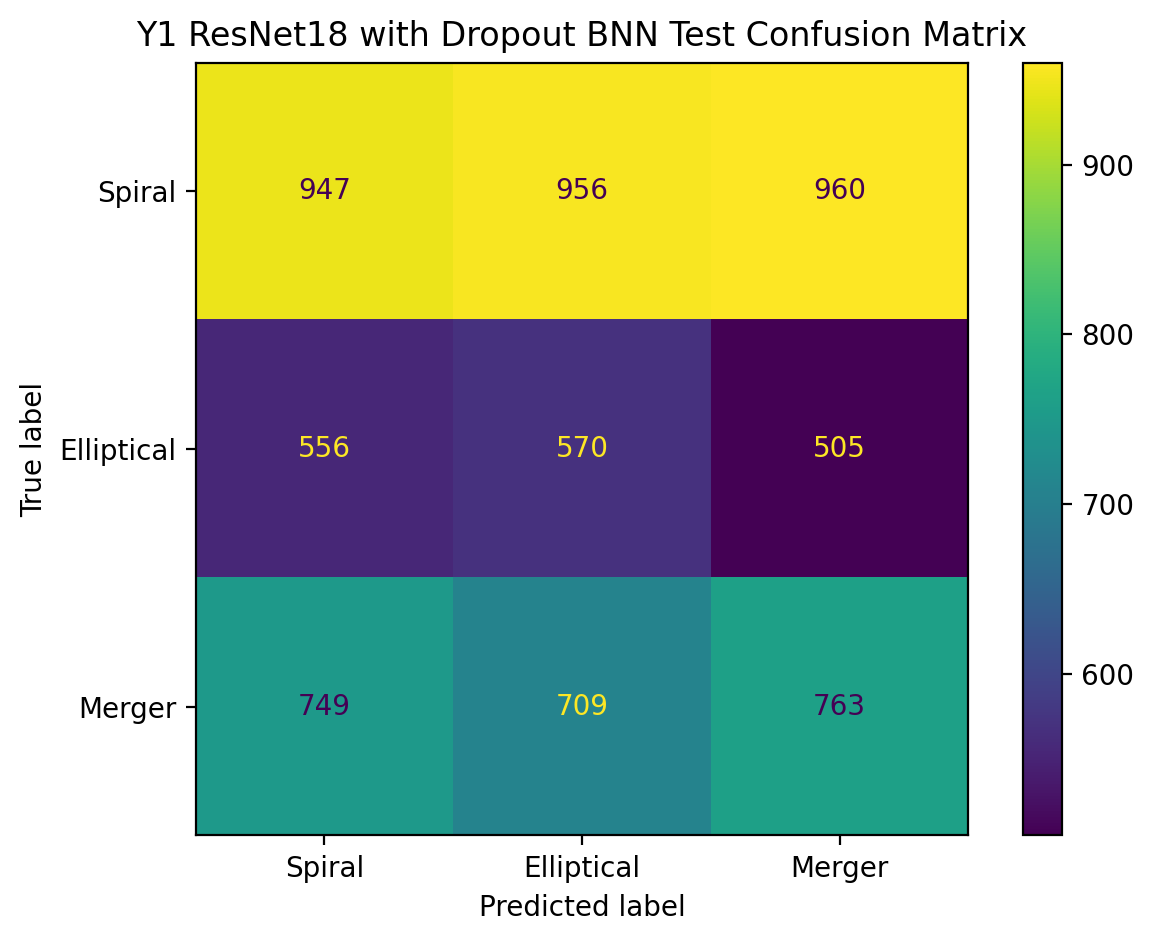

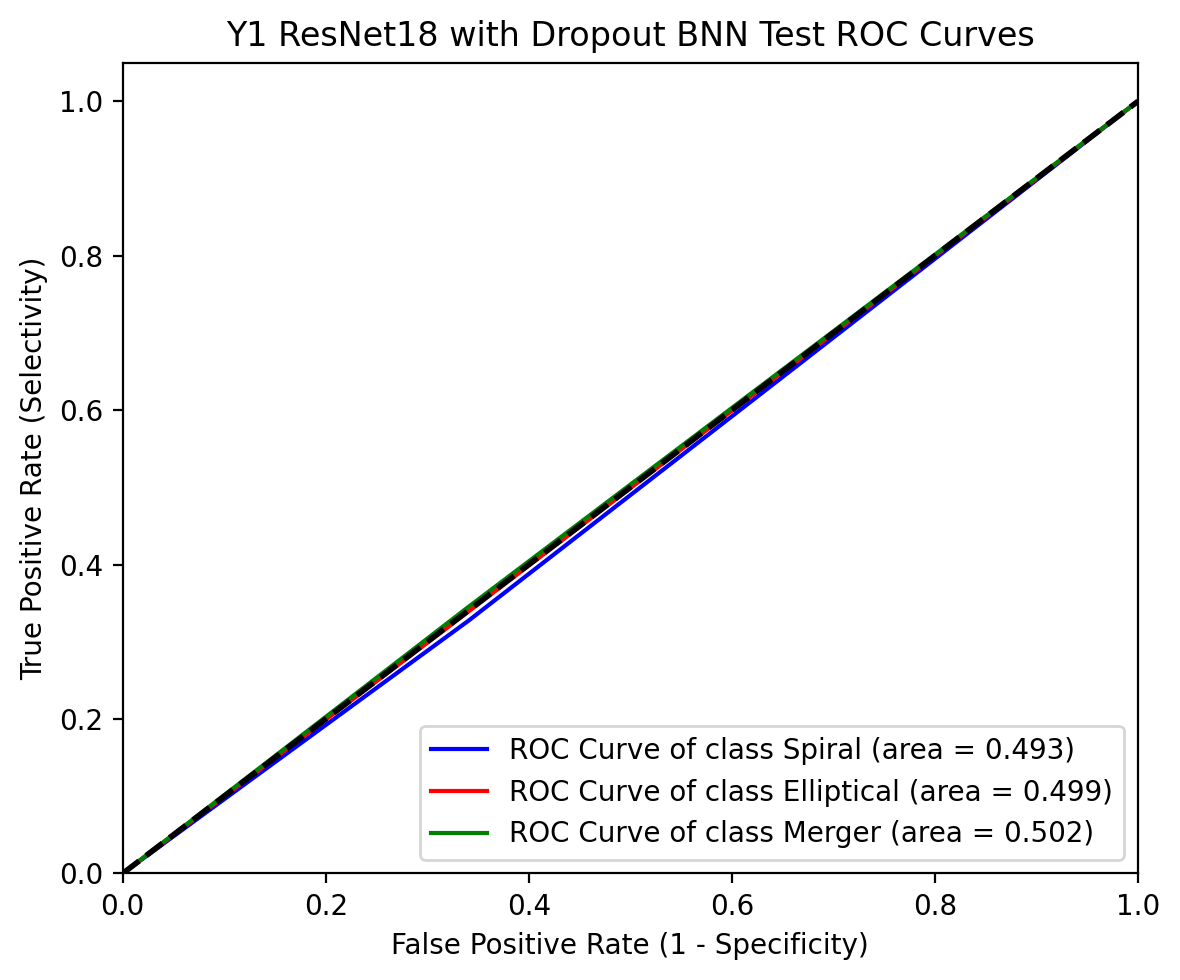

In [41]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = bnn_model.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(bnn_model.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y1 ResNet18 with Dropout BNN Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_Dropout_BNN_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 with Dropout BNN Test ROC Curves')
plt.savefig('Y1_ResNet18_Dropout_BNN_test_ROC')
plt.show()

#### Analyze BNN Model Predictions and Outputs

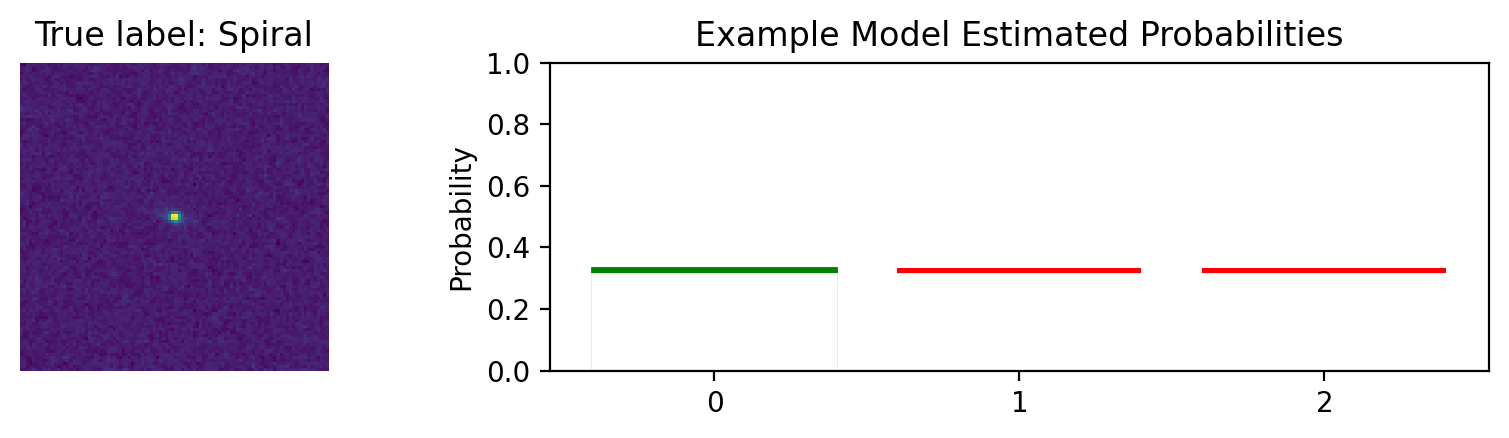

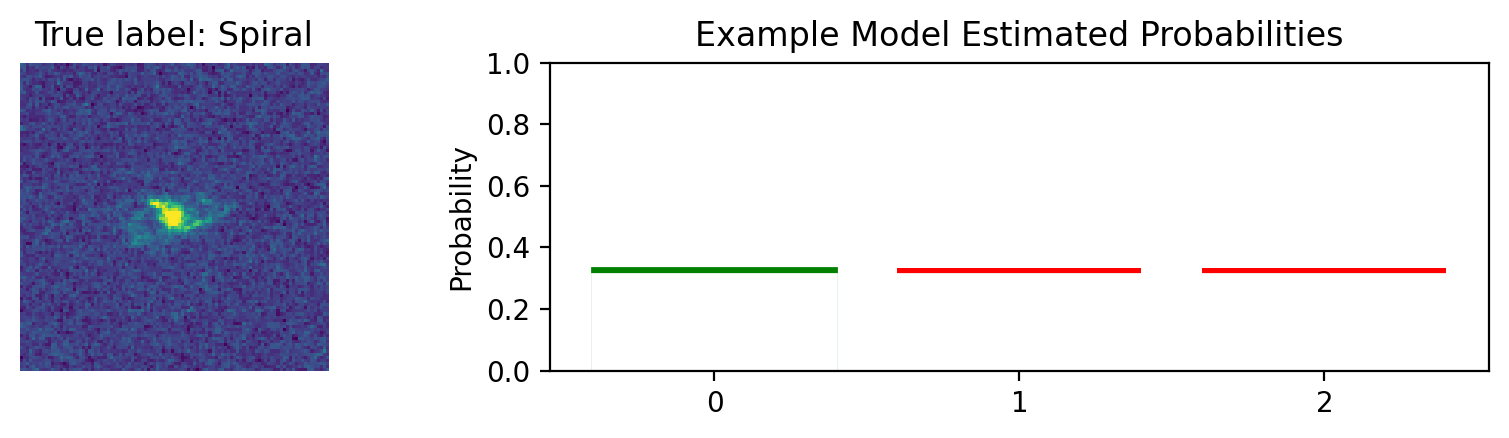

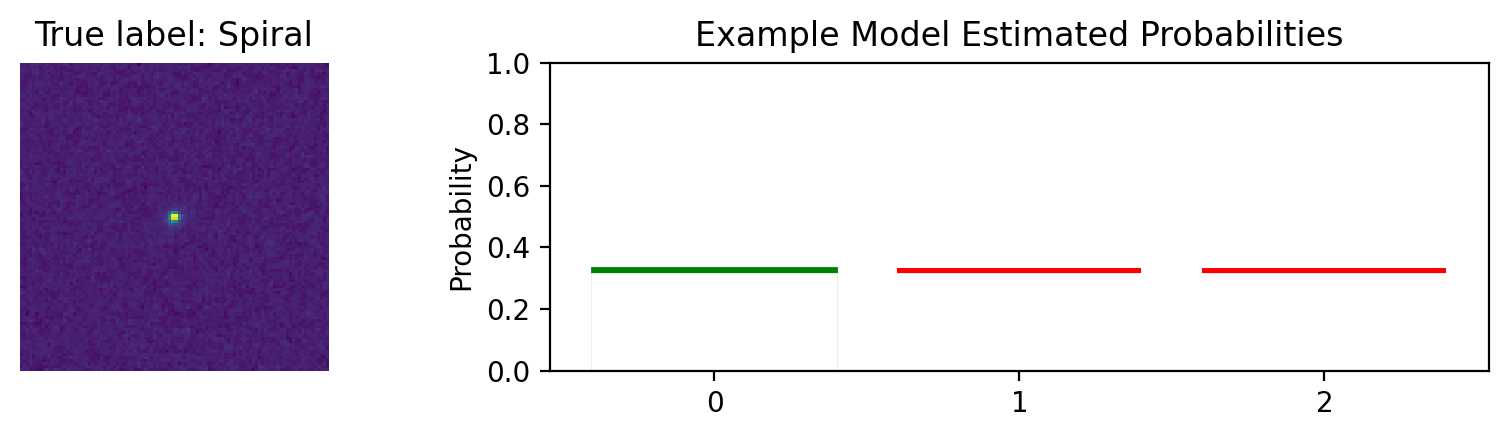

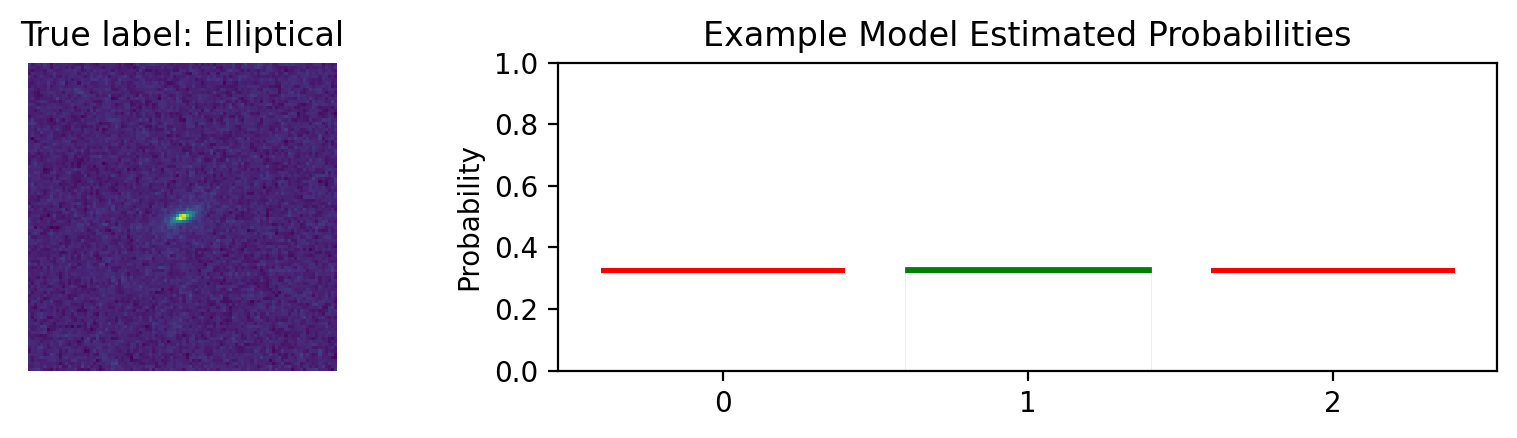

KeyboardInterrupt: 

In [90]:
# Evaluate and visualize for Y1 test data
for i in examples:
    analyse_model_prediction(X_test_1, Y_test, bayesian_resnet18_model, i, run_ensemble=True)

In [ ]:
# Evaluate and visualize for Y10 test data
for i in examples:
    analyse_model_prediction(X_test_10, Y_test, bayesian_resnet18_model, i, run_ensemble=True)